# Test de différents modèles avec la consommation d'énergie en variable cible

In [486]:
!pip install shap

**Import de packages**

In [487]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
import timeit, time
from google.colab import files
import copy, math
import xgboost
from xgboost import XGBRegressor
import shap
import sys

In [488]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("XGBoost version:", xgboost.__version__)
print("SHAP version:", shap.__version__)
print("Python version:", sys.version)

Pandas version: 1.5.3
NumPy version: 1.23.5
scikit-learn version: 1.2.2
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
XGBoost version: 2.0.3
SHAP version: 0.44.1
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


**Import du jeu de données**

In [489]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [490]:
data = pd.read_csv("/content/drive/My Drive/Formation/Notebooks/jeu_données_outliers_new.csv", index_col = 0)

**Config d'options**

In [491]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## 1.Préparation des données et création d'une liste de variables explicatives

In [492]:
data.head()

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age_Bati,Steam %,Elec %,NaturalGas %,UseTypesNumber,Surf_1er_type_prop,Surf_2e_type_prop,Surf_3e_type_prop,Surf_batie_prop,Surf_parking_prop
0,Hotel,47.6122,-122.3380,1.0000,12,88434,0,88434,Hotel,NaN,60.0000,7226362.5000,249.9800,89,27.7302,54.6060,17.6638,1,100.0000,0.0000,0.0000,100.0000,0.0000
1,Hotel,47.6132,-122.3339,1.0000,11,103566,15064,88502,"Hotel, Parking, Restaurant",15064.0000,61.0000,8387933.0000,295.8600,20,0.0000,38.6609,61.3391,3,80.9918,14.5453,4.4629,85.4547,14.5453
2,Hotel,47.6139,-122.3381,1.0000,41,956110,196718,759392,Hotel,NaN,43.0000,72587024.0000,2089.2800,47,29.7113,68.2307,2.0579,1,100.0000,0.0000,0.0000,79.4252,20.5748
3,Hotel,47.6141,-122.3366,1.0000,10,61320,0,61320,Hotel,NaN,56.0000,6794584.0000,286.4300,90,32.5913,40.7519,26.6567,1,100.0000,0.0000,0.0000,100.0000,0.0000
4,Hotel,47.6138,-122.3405,1.0000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",68009.0000,75.0000,14172606.0000,505.0100,36,0.0000,37.8802,62.1198,3,64.4776,35.5224,0.0000,64.6885,35.3115


In [493]:
data.shape

(1624, 23)

In [494]:
data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    290
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    125
Mixed Use Property             113
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     39
Medical Office                  39
Self-Storage Facility           28
University                      24
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

Pour faire en sorte que toutes les modalités de type d'usage soient présentes à la fois dans les jeu de données train et test, je décide de placer les modalités dont les occurrences sont < 10 dans une autre modalité. Je regarde les différents moyennes pour voir si je place 'Office' dans 'Small- and Mid-Sized Office' ou dans 'Other' :

In [495]:
data.groupby('PrimaryPropertyType')['PropertyGFATotal'].mean().sort_values()

PrimaryPropertyType
Office                         13784.3333
Restaurant                     30941.9167
Worship Facility               32938.2958
Refrigerated Warehouse         38833.5000
Small- and Mid-Sized Office    46782.3310
Self-Storage Facility          54324.2857
Supermarket / Grocery Store    58207.8462
Warehouse                      61268.2460
Distribution Center            64481.9623
K-12 School                    76424.3440
Retail Store                   82523.6813
Other                          96295.5121
Mixed Use Property            103330.0088
Laboratory                    120321.1000
Senior Care Community         128424.5500
Hotel                         159453.2368
Medical Office                162192.7949
Large Office                  359938.9364
Hospital                      621300.4000
University                    626394.4583
Name: PropertyGFATotal, dtype: float64

In [496]:
print(data.loc[data['PrimaryPropertyType'] == 'Small- and Mid-Sized Office', 'PropertyGFATotal'].min())
print(data.loc[data['PrimaryPropertyType'] == 'Other', 'PropertyGFATotal'].min())
print(data.loc[data['PrimaryPropertyType'] == 'Office', 'PropertyGFATotal'])

20022
11285
3366    13661
3369    15398
3371    12294
Name: PropertyGFATotal, dtype: int64


Je fais le choix de supprimer la modalité 'Office' et de transférer les individus concernés dans la modalité 'Small- and Mid-Sized Office'.

In [497]:
data.loc[data['PrimaryPropertyType'] == 'Office', 'PrimaryPropertyType'] = 'Small- and Mid-Sized Office'

In [498]:
data.groupby('PrimaryPropertyType')['PropertyGFATotal'].mean().sort_values()

PrimaryPropertyType
Restaurant                     30941.9167
Worship Facility               32938.2958
Refrigerated Warehouse         38833.5000
Small- and Mid-Sized Office    46444.4676
Self-Storage Facility          54324.2857
Supermarket / Grocery Store    58207.8462
Warehouse                      61268.2460
Distribution Center            64481.9623
K-12 School                    76424.3440
Retail Store                   82523.6813
Other                          96295.5121
Mixed Use Property            103330.0088
Laboratory                    120321.1000
Senior Care Community         128424.5500
Hotel                         159453.2368
Medical Office                162192.7949
Large Office                  359938.9364
Hospital                      621300.4000
University                    626394.4583
Name: PropertyGFATotal, dtype: float64

Je crée une variable correspondant au log de la surface totale et je testerai son implentation à la place de la variable 'brute' dans les modèles.

In [499]:
# Création de variable :
data['log_PropertyGFATotal'] = np.log1p(data['PropertyGFATotal'])

In [500]:
# Etablissement de plusieurs choix de variables explicatives :

var_exp = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

numerical_features = ['NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

categorical_features = ['PrimaryPropertyType']

var_exp2 = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

numerical_features2 = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

var_exp3 = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

numerical_features3 = ['NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

var_exp4 = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

numerical_features4 = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

## 2.Instanciation de différents "transformeurs" et split des données

J'instancie différentes façons de transformer mes variables, on en testera et comparera les résultats en utilisant plusieurs modèles.

J'instancie également un transformateur de ma variable cible. On a vu dans le notebook de nettoyage des données qu'un passage au log rapprochait les distributions des deux variables choisies d'une distribution normale.

In [501]:
# Pour les variables explicatives :
robust_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (RobustScaler(), numerical_features2), remainder='passthrough')
stand_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numerical_features2), remainder='passthrough')
minmax_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (MinMaxScaler(), numerical_features2), remainder='passthrough')
log_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (FunctionTransformer(func = np.log1p, inverse_func = np.expm1), numerical_features), remainder='passthrough')

# Pour la variable cible :
target_transfo = FunctionTransformer(func = np.log1p, inverse_func = np.expm1)

Je sépare mes variables entre variables explicatives (exogènes) d'un coté et expliquée (endogène) de l'autre :

In [502]:
X = data[var_exp2]
y = data['SiteEnergyUse(kBtu)']

Puis je crée des jeux de données d'entrainement et de test :

In [503]:
# split des données :

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=30)

**Transformation des données :**

In [504]:
# Je transforme les données explicatives :
X_train_scaled = stand_transformer.fit_transform(X_train)
X_test_scaled = stand_transformer.transform(X_test)

# Et cible :
y_train_scaled = target_transfo.fit_transform(y_train)
y_test_scaled = target_transfo.transform(y_test)

Création d'un DF Xtrain_scaled pour l'analyse de feature

In [505]:
"""
# 1) Cas du log transformer :

# Obtenir les noms des colonnes après la transformation
column_names = []

# Noms des colonnes après encodage OneHot
column_names += list(log_transformer.named_transformers_['onehotencoder'].get_feature_names_out(categorical_features))

# Noms des colonnes après transformation logarithmique
column_names += numerical_features

# Ajouter le reste des colonnes non transformées
column_names += ['Latitude', 'Longitude']

# Créer un DataFrame à partir du np.array transformé
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)

# Changement nom des colonnes :
X_train_scaled_df.rename(columns=lambda x: x.replace('PrimaryPropertyType_', ''), inplace=True)

#Affichage
X_train_scaled_df.head()
"""

# 2) Autres cas (à adapter) :

# Pour les features importances on récupères les noms de colonnes de nos jeu de données :
feature_names_encoded = stand_transformer.get_feature_names_out(X_train.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = feature_names_encoded)
X_train_scaled_df.rename(columns=lambda x: x.replace('onehotencoder__PrimaryPropertyType_', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('standardscaler__', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)


## 3.Fonctions

On définit différentes fonctions :
- une fonction de cross validation
- une fonction d'affichage de résultats/performances via différentes métriques
- une fonction qui permettra de retourner ces résultats
- une fonction d'application d'une GridSearchCV
- une fonction de finetuning dans laquelle on modifiera les hypermaramètres de manière itérative

In [506]:
# Définition de différentes fonctions permettant d'évaluer les modèles :

def cross_val(model, X, y):
  """
  Je définis ici une fonction qui applique une cross-validation que j'utiliserai pour entrainer
  et évaluer des modèles sur mon jeu de données d'entraînement. Je choisis un nombre de splits égal à 10,
  il y aura 10 itérations au cours desquelles les modèles s'entraineront sur 10-1 échantillons
  et seront testés sur l'échantillon restant, utilisé comme validation set et sur lequel on
  évaluera les performances du modèle.
  """
  # on fixe un random_state :
  random_state = 42
  np.random.seed(random_state)

  # On crée un objet KFold avec le générateur de nombres aléatoires
  kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
  # En choisissant 10 splits, cela retourne 10 scores
  pred = cross_val_score(model, X, y, cv=kf)
  # La fonction renvoie la moyenne de ces 10 scores
  return pred.mean()

def print_evaluate(true_test, predicted_test, true_train, predicted_train):

  # Mise à l'échelle prédictions et variable cible :
  predict_test_originalscale = target_transfo.inverse_transform(predicted_test)
  predict_train_originalscale = target_transfo.inverse_transform(predicted_train)

  true_test_originalscale = target_transfo.inverse_transform(true_test)
  true_train_originalscale = target_transfo.inverse_transform(true_train)

  # Calcul des métriques :
  mae_train = mean_absolute_error(true_train, predicted_train)
  mae_test = mean_absolute_error(true_test, predicted_test)

  mse_train = mean_squared_error(true_train, predicted_train)
  mse_test = mean_squared_error(true_test, predicted_test)

  rmse_train = np.sqrt(mean_squared_error(true_train, predicted_train))
  rmse_test = np.sqrt(mean_squared_error(true_test, predicted_test))

  r2_train = r2_score(true_train, predicted_train)
  r2_test = r2_score(true_test, predicted_test)

  # Affichage :
  print(f'MAE train: {mae_train} \t\t MAE test: {mae_test}')
  print(f'MSE train: {mse_train} \t\t MSE test: {mse_test}')
  print(f'RMSE train: {rmse_train} \t\t RMSE test: {rmse_test}')
  print(f'R2 train: {r2_train} \t\t R2 test: {r2_test}')
  print('__________________________________')

def evaluate(true_test, predicted_test, true_train, predicted_train):
  # Mise à l'échelle prédictions et variable cible :
  predict_test_originalscale = target_transfo.inverse_transform(predicted_test)

  true_test_originalscale = target_transfo.inverse_transform(true_test)

  # Calcul des métriques :
  mae = mean_absolute_error(true_test, predicted_test)
  mse = mean_squared_error(true_test, predicted_test)
  rmse = np.sqrt(mean_squared_error(true_test, predicted_test))
  r2_test = r2_score(true_test, predicted_test)
  r2_train = r2_score(true_train, predicted_train)
  return mae, rmse, r2_test, r2_train

def grid_search_cv_regression(X, y, model_name):


  if model_name == 'linear':
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False]}
  elif model_name == 'ridge':
    model = Ridge()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.01, 0.03, 0.1, 0.3, 1]}
  elif model_name == 'lasso':
    model = Lasso()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.01, 0.03, 0.1, 0.3, 1]}
  elif model_name == 'svr':
    model = SVR()
    param_grid = {'gamma' : [0.01, 0.1, 1],
                  'C' : [0.1, 0.5, 1, 10],
                  'epsilon' : [0.01, 0.03, 0.1, 0.3]}
  elif model_name == 'eln':
    model = ElasticNet(random_state = 42)
    param_grid = {'alpha' : [0.01, 0.03, 0.1, 0.5],
                  'l1_ratio' : [0.1, 0.5, 0.9],
                  'tol' : [0.001, 0.01, 0.1]}
  elif model_name == 'random_forest':
    model = RandomForestRegressor(random_state = 42)
    param_grid = {'n_estimators': [400, 500, 600],
                  'max_depth': [None, 10, 20],
                  'max_features' : [None, 'sqrt', 'log2']}
  elif model_name == 'gradient_boost':
    model = GradientBoostingRegressor(random_state = 42)
    param_grid = {'n_estimators': [50, 100, 200, 500],
                  'max_depth': [None, 3, 5, 7],
                  'learning_rate': [0.01, 0.03, 0.1]}
  elif model_name == 'xgboost':
    model = XGBRegressor(random_state = 42)
    param_grid = {'n_estimators': [50, 100, 200, 500],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.03, 0.1],
                  'min_child_weight' : [0.5, 2]}

  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='r2')
  grid_search.fit(X, y)

  best_params = grid_search.best_params_

  best_model = grid_search.best_estimator_

  best_score = round(grid_search.best_score_, 4)

  return best_params, best_model, best_score

**On applique une correction ici à notre fonction de finetuning en lui faisant aussi retourner l'attribut 'best_score_' de GridSearchCV afin de pouvoir enregistré le R2_cv par ce biais**

In [377]:
# On définit une fonction de finetuning :

def fine_grid_search_cv_regression(X, y, model_name):


  if model_name == 'ridge':
    model = Ridge()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.8, 1, 1.2]}
  elif model_name == 'lasso':
    model = Lasso()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.006, 0.008, 0.01]}
  elif model_name == 'svr':
    model = SVR()
    param_grid = {'gamma' : [0.0045, 0.005, 0.0055],
                  'C' : [45],
                  'epsilon' : [0.3, 0.4]}
  elif model_name == 'eln':
    model = ElasticNet(random_state = 42)
    param_grid = {'alpha': [0.001, 0.005, 0.01],
                  'l1_ratio' : [0.001, 0.005, 0.1],
                  'tol' : [0.005, 0.01, 0.03]}
  elif model_name == 'random_forest':
    model = RandomForestRegressor(random_state = 42)
    param_grid = {'n_estimators': [500, 600],
                  'max_depth': [18, 20, 22],
                  'min_samples_split' : [2, 5]}
                  #'ccp_alpha' : [0.0, 0.1, 1.0]
  elif model_name == 'gradient_boost':
    model = GradientBoostingRegressor(random_state = 42)
    param_grid = {'n_estimators': [80, 100, 120],
                  'learning_rate': [0.08, 0.1, 0.3],
                  'min_weight_fraction_leaf' : [0.0, 0.5]}
  elif model_name == 'xgboost':
    model = XGBRegressor(random_state = 42)
    param_grid = {
    'max_depth': [3, 4],
    'min_child_weight': [4, 5],
    'subsample': [0.7, 0.9],
    'learning_rate': [0.02, 0.03],
    'n_estimators': [450, 550],
    'gamma': [0.1, 0.2],
    'colsample_bytree' : [0.8, 0.9],
    'reg_lambda' : [0.9, 1.1]
    }

  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='r2')
  grid_search.fit(X, y)

  best_params = grid_search.best_params_

  best_model = grid_search.best_estimator_

  best_score = round(grid_search.best_score_, 4)

  return best_params, best_model, best_score

## 4.Baseline : Dummy Regressor

On prend comme baseline un dummy regressor et nous comparerons les résultats des autres modèles avec celui-ci :

In [28]:
# On instancie et entraine le modèle
dummy_reg = DummyRegressor(strategy = 'mean')
start_time = time.time()
dummy_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

**Lorsque l'on utilise la notre fonction de cross-validation, on enregistre directement le score moyen qu'elle retourne dans une variable nommée r2_cv, qui correspond donc au R2 calculé sur le jeu de validation.**

In [29]:
# cross val score :
r2_cv = cross_val(dummy_reg, X_train_scaled, y_train_scaled)

-0.0035962632834315887

In [30]:
pred_train = dummy_reg.predict(X_train_scaled)
pred_test = dummy_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0520464322169345 		 MAE test: 1.02566695370425
MSE train: 1.788622230237133 		 MSE test: 1.6408085353836541
RMSE train: 1.3373938201730757 		 RMSE test: 1.280940488619067
R2 train: 0.0 		 R2 test: -0.00030104961604493496
__________________________________


In [31]:
# On récupère les résultats dans un Dataframe :
results_dummy = pd.DataFrame(data=[["Dummy Regression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(results_dummy)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0061


On voit que le modèle n'est pas très performant.

## 5.Test de modèles avec paramètres par défaut et analyse des résultats (random_state split : 30 / random_state cv : 42) :

**LinearRegression**

In [32]:
# On instancie et entraine le modèle
lin_reg = LinearRegression()
start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lin_reg, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.6711732501297797 		 MAE test: 0.6474518859072229
MSE train: 0.7949207250957808 		 MSE test: 0.7355946982151391
RMSE train: 0.8915832687392585 		 RMSE test: 0.8576681748876654
R2 train: 0.5555681285531202 		 R2 test: 0.5515527053590364
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df = pd.DataFrame(data=[["LinearRegression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086


**Ridge**

In [ ]:
# On instancie et entraine le modèle
ridge = Ridge()
start_time = time.time()
ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(ridge, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = ridge.predict(X_train_scaled)
pred_test = ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.6712134809008137 		 MAE test: 0.6468324849571888
MSE train: 0.7948618610274258 		 MSE test: 0.727482847641182
RMSE train: 0.8915502571517917 		 RMSE test: 0.8529260505115211
R2 train: 0.5556010388386796 		 R2 test: 0.5564980066958316
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Ridge", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070


**Lasso**

In [ ]:
# On instancie et entraine le modèle
lasso = Lasso()
start_time = time.time()
lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lasso, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lasso.predict(X_train_scaled)
pred_test = lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0520464322169345 		 MAE test: 1.02566695370425
MSE train: 1.788622230237133 		 MSE test: 1.6408085353836541
RMSE train: 1.3373938201730757 		 RMSE test: 1.280940488619067
R2 train: 0.0 		 R2 test: -0.00030104961604493496
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Lasso", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031


**ElasticNet**

In [ ]:
# On instancie et entraine le modèle
eln = ElasticNet(random_state = 42)
start_time = time.time()
eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(eln, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = eln.predict(X_train_scaled)
pred_test = eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0303966595014975 		 MAE test: 1.005711525871336
MSE train: 1.6983652209816595 		 MSE test: 1.5663194041054225
RMSE train: 1.3032134211178381 		 RMSE test: 1.2515268291592563
R2 train: 0.05046175079882975 		 R2 test: 0.045110437827966976
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["ElasticNet", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
3,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077


**SVR**

In [ ]:
# On instancie et entraine le modèle
svr = SVR()
start_time = time.time()
svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(svr, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = svr.predict(X_train_scaled)
pred_test = svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.988578778571121 		 MAE test: 0.9660683848405086
MSE train: 1.6129044683908975 		 MSE test: 1.4856205408266328
RMSE train: 1.2700017592077963 		 RMSE test: 1.2188603450874234
R2 train: 0.09824196461146462 		 R2 test: 0.09430762074103638
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
3,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077
4,SVR,0.9661,1.2189,0.0943,0.0982,0.0847,0.1001


**RandomForest**

In [ ]:
# On instancie et entraine le modèle
rf = RandomForestRegressor(random_state = 42)
start_time = time.time()
rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(rf, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = rf.predict(X_train_scaled)
pred_test = rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.19789636453752205 		 MAE test: 0.529524188143683
MSE train: 0.07306124076019865 		 MSE test: 0.5039312102170497
RMSE train: 0.2702984290746039 		 RMSE test: 0.7098811240039065
R2 train: 0.9591522236920245 		 R2 test: 0.6927838272144691
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
3,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077
4,SVR,0.9661,1.2189,0.0943,0.0982,0.0847,0.1001
5,RandomForest,0.5295,0.7099,0.6928,0.9592,0.7117,1.7331


**GradientBoost**

In [ ]:
# On instancie et entraine le modèle
gb = GradientBoostingRegressor(random_state = 42)
start_time = time.time()
gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(gb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = gb.predict(X_train_scaled)
pred_test = gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.40904962196990685 		 MAE test: 0.5023010364617244
MSE train: 0.3152908008759406 		 MSE test: 0.45181146673599487
RMSE train: 0.5615076142635472 		 RMSE test: 0.6721692247760194
R2 train: 0.8237242076354269 		 R2 test: 0.7245580610665789
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["GradientBoost", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
3,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077
4,SVR,0.9661,1.2189,0.0943,0.0982,0.0847,0.1001
5,RandomForest,0.5295,0.7099,0.6928,0.9592,0.7117,1.7331
6,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4417


**XGB**

In [ ]:
# On instancie et entraine le modèle
xgb = XGBRegressor(random_state = 42)
start_time = time.time()
xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(xgb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = xgb.predict(X_train_scaled)
pred_test = xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.06971396578461872 		 MAE test: 0.5497112307278053
MSE train: 0.009990062587795594 		 MSE test: 0.5455944864993213
RMSE train: 0.09995030058882061 		 RMSE test: 0.7386436803353301
R2 train: 0.9944146603911598 		 R2 test: 0.6673842646836374
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["XGB", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
1,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
3,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077
4,SVR,0.9661,1.2189,0.0943,0.0982,0.0847,0.1001
5,RandomForest,0.5295,0.7099,0.6928,0.9592,0.7117,1.7331
6,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4417
7,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,1.0287


**Après plusieurs changements de random_state, à la fois pour le split et pour la cross validation, nous n'avons pas noté de changements significatifs dans les résultats.**

In [ ]:
default_std_results_df_global = pd.concat([results_dummy, default_std_results_df], ignore_index = True)
display(default_std_results_df_global)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0071
1,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
2,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
3,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
4,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077
5,SVR,0.9661,1.2189,0.0943,0.0982,0.0847,0.1001
6,RandomForest,0.5295,0.7099,0.6928,0.9592,0.7117,1.7331
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4417
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,1.0287


On voit qu'on a globalement de meilleurs résultats que ceux de notre baseline, excepté pour le modèle Lasso. Cependant les performances ne sont pas satisfaisantes, excepté pour les modèles RandomForest, GradientBoost et XGB qui obtiennent déjà des scores assez élevé. On note cependant la présence d'overfitting, très nettement pour le RandomForest et le XGB.

## 6.Transformation de la variable "surface totale" par son log :

On prend comme baseline un dummy regressor et nous comparerons les résultats des autres modèles avec celui-ci :

In [ ]:
# On instancie et entraine le modèle
dummy_reg = DummyRegressor(strategy = 'mean')
start_time = time.time()
dummy_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(dummy_reg, X_train_scaled, y_train_scaled)

-0.0035962632834315887

In [ ]:
pred_train = dummy_reg.predict(X_train_scaled)
pred_test = dummy_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0520464322169345 		 MAE test: 1.02566695370425
MSE train: 1.788622230237133 		 MSE test: 1.6408085353836541
RMSE train: 1.3373938201730757 		 RMSE test: 1.280940488619067
R2 train: 0.0 		 R2 test: -0.00030104961604493496
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
results_dummy_sflog = pd.DataFrame(data=[["Dummy Regression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(results_dummy_sflog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0023


**LinearRegression**

In [ ]:
# On instancie et entraine le modèle
lin_reg = LinearRegression()
start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lin_reg, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.47749023508738314 		 MAE test: 0.49262231436081455
MSE train: 0.44815193083959365 		 MSE test: 0.4465434328745975
RMSE train: 0.6694415066602859 		 RMSE test: 0.6682390536885715
R2 train: 0.7494429381098666 		 R2 test: 0.7277696605233898
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_log = pd.DataFrame(data=[["LinearRegression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055


**Ridge**

In [ ]:
# On instancie et entraine le modèle
ridge = Ridge()
start_time = time.time()
ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(ridge, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = ridge.predict(X_train_scaled)
pred_test = ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4765091401306792 		 MAE test: 0.4955820073994144
MSE train: 0.44623085876785035 		 MSE test: 0.4526965654598603
RMSE train: 0.6680051337885439 		 RMSE test: 0.6728272924457362
R2 train: 0.7505169894323132 		 R2 test: 0.7240184702713072
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Ridge", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073


**Lasso**

In [ ]:
# On instancie et entraine le modèle
lasso = Lasso()
start_time = time.time()
lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lasso, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lasso.predict(X_train_scaled)
pred_test = lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0325278080966949 		 MAE test: 1.00555613888435
MSE train: 1.7246666237194697 		 MSE test: 1.580102141678894
RMSE train: 1.3132656333428776 		 RMSE test: 1.2570211381193612
R2 train: 0.035756911345770415 		 R2 test: 0.036707942007147554
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Lasso", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064


**ElasticNet**

In [ ]:
# On instancie et entraine le modèle
eln = ElasticNet(random_state = 42)
start_time = time.time()
eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(eln, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = eln.predict(X_train_scaled)
pred_test = eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.842874081948239 		 MAE test: 0.8129910816385971
MSE train: 1.1832132994694702 		 MSE test: 1.0729655821653734
RMSE train: 1.0877560845472067 		 RMSE test: 1.0358405196580087
R2 train: 0.3384778074056468 		 R2 test: 0.345878221074126
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["ElasticNet", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0127


**SVR**

In [ ]:
# On instancie et entraine le modèle
svr = SVR()
start_time = time.time()
svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(svr, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = svr.predict(X_train_scaled)
pred_test = svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.9468629144808287 		 MAE test: 0.9234449112133231
MSE train: 1.494870556476358 		 MSE test: 1.368453564211615
RMSE train: 1.2226489915246967 		 RMSE test: 1.169809199917497
R2 train: 0.1642334914521496 		 R2 test: 0.16573719168786039
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0127
4,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.1514


**RandomForest**

In [ ]:
# On instancie et entraine le modèle
rf = RandomForestRegressor(random_state = 42)
start_time = time.time()
rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(rf, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = rf.predict(X_train_scaled)
pred_test = rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.19785974838063178 		 MAE test: 0.5296029467412473
MSE train: 0.07303297875500671 		 MSE test: 0.5041686542911364
RMSE train: 0.27024614475512265 		 RMSE test: 0.7100483464463081
R2 train: 0.9591680246838238 		 R2 test: 0.692639072021275
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0127
4,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.1514
5,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,1.4047


**GradientBoost**

In [ ]:
# On instancie et entraine le modèle
gb = GradientBoostingRegressor(random_state = 42)
start_time = time.time()
gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(gb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = gb.predict(X_train_scaled)
pred_test = gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.40904962196990685 		 MAE test: 0.5023010364617244
MSE train: 0.3152908008759406 		 MSE test: 0.45181146673599487
RMSE train: 0.5615076142635472 		 RMSE test: 0.6721692247760194
R2 train: 0.8237242076354269 		 R2 test: 0.7245580610665789
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["GradientBoost", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0127
4,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.1514
5,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,1.4047
6,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.6506


**XGB**

In [ ]:
# On instancie et entraine le modèle
xgb = XGBRegressor(random_state = 42)
start_time = time.time()
xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(xgb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = xgb.predict(X_train_scaled)
pred_test = xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.06971396578461872 		 MAE test: 0.5497112307278053
MSE train: 0.009990062587795594 		 MSE test: 0.5455944864993213
RMSE train: 0.09995030058882061 		 RMSE test: 0.7386436803353301
R2 train: 0.9944146603911598 		 R2 test: 0.6673842646836374
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["XGB", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0127
4,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.1514
5,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,1.4047
6,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.6506
7,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,0.3312


In [ ]:
default_std_results_df_global_log = pd.concat([results_dummy_sflog, default_std_results_df_log], ignore_index = True)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0063
1,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0156
2,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0152
3,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0074
4,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0095
5,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.4844
6,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,2.3396
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4249
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,2.8612


In [ ]:
display(default_std_results_df_global, default_std_results_df_global_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0071
1,LinearRegression,0.6475,0.8577,0.5516,0.5556,0.3005,0.0086
2,Ridge,0.6468,0.8529,0.5565,0.5556,0.3041,0.0070
3,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
4,ElasticNet,1.0057,1.2515,0.0451,0.0505,0.0364,0.0077
5,SVR,0.9661,1.2189,0.0943,0.0982,0.0847,0.1001
6,RandomForest,0.5295,0.7099,0.6928,0.9592,0.7117,1.7331
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4417
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,1.0287


,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0063
1,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0156
2,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0152
3,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0074
4,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0095
5,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.4844
6,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,2.3396
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4249
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,2.8612


Ce changement de variable a l'air d'impacter positivement les modèles qui avaient de moins bonnes performances sans réduire celles des modèles dont les scores étaient plutôt bons. Nous conserverons donc cette transformation de variable à l'avenir.

**Je tente de changer de transformation de variable :**

On prend comme baseline un dummy regressor et nous comparerons les résultats des autres modèles avec celui-ci :

In [ ]:
# On instancie et entraine le modèle
dummy_reg = DummyRegressor(strategy = 'mean')
start_time = time.time()
dummy_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(dummy_reg, X_train_scaled, y_train_scaled)

-0.0035962632834315887

In [ ]:
pred_train = dummy_reg.predict(X_train_scaled)
pred_test = dummy_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0520464322169345 		 MAE test: 1.02566695370425
MSE train: 1.788622230237133 		 MSE test: 1.6408085353836541
RMSE train: 1.3373938201730757 		 RMSE test: 1.280940488619067
R2 train: 0.0 		 R2 test: -0.00030104961604493496
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
results_dummy_loglog = pd.DataFrame(data=[["Dummy Regression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(results_dummy_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0023


**LinearRegression**

In [ ]:
# On instancie et entraine le modèle
lin_reg = LinearRegression()
start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lin_reg, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4800962301995275 		 MAE test: 0.49647513494780887
MSE train: 0.4534367823282766 		 MSE test: 0.45740278880542334
RMSE train: 0.6733771471681205 		 RMSE test: 0.6763155985229258
R2 train: 0.7464882328628104 		 R2 test: 0.7211493724754492
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_loglog = pd.DataFrame(data=[["LinearRegression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048


**Ridge**

In [ ]:
# On instancie et entraine le modèle
ridge = Ridge()
start_time = time.time()
ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(ridge, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = ridge.predict(X_train_scaled)
pred_test = ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4808740772231273 		 MAE test: 0.499281155476496
MSE train: 0.45389464366549487 		 MSE test: 0.4588524378646213
RMSE train: 0.6737170353089603 		 RMSE test: 0.6773864759977286
R2 train: 0.7462322473732655 		 R2 test: 0.7202656097181135
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Ridge", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075


**Lasso**

In [ ]:
# On instancie et entraine le modèle
lasso = Lasso()
start_time = time.time()
lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lasso, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lasso.predict(X_train_scaled)
pred_test = lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0520464322169345 		 MAE test: 1.02566695370425
MSE train: 1.788622230237133 		 MSE test: 1.6408085353836541
RMSE train: 1.3373938201730757 		 RMSE test: 1.280940488619067
R2 train: 0.0 		 R2 test: -0.00030104961604493496
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Lasso", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083


**ElasticNet**

In [ ]:
# On instancie et entraine le modèle
eln = ElasticNet(random_state = 42)
start_time = time.time()
eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(eln, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = eln.predict(X_train_scaled)
pred_test = eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.8560392749191985 		 MAE test: 0.8262414911791125
MSE train: 1.2159410302347538 		 MSE test: 1.1031069522408927
RMSE train: 1.1026971616154426 		 RMSE test: 1.0502889851088093
R2 train: 0.32018007509973423 		 R2 test: 0.3275028631495296
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["ElasticNet", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083
3,ElasticNet,0.8262,1.0503,0.3275,0.3202,0.3198,0.0126


**SVR**

In [ ]:
# On instancie et entraine le modèle
svr = SVR()
start_time = time.time()
svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(svr, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = svr.predict(X_train_scaled)
pred_test = svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.9524724818715078 		 MAE test: 0.9331074558922343
MSE train: 1.5180051888268873 		 MSE test: 1.4012114733703747
RMSE train: 1.2320735322321015 		 RMSE test: 1.1837277868540448
R2 train: 0.15129916023372236 		 R2 test: 0.14576668921416813
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083
3,ElasticNet,0.8262,1.0503,0.3275,0.3202,0.3198,0.0126
4,SVR,0.9331,1.1837,0.1458,0.1513,0.1365,0.0997


**RandomForest**

In [ ]:
# On instancie et entraine le modèle
rf = RandomForestRegressor(random_state = 42)
start_time = time.time()
rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(rf, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = rf.predict(X_train_scaled)
pred_test = rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.19750645745077655 		 MAE test: 0.5294201708411795
MSE train: 0.07290681258125216 		 MSE test: 0.5041459626568808
RMSE train: 0.27001261559647943 		 RMSE test: 0.7100323673304484
R2 train: 0.9592385628732869 		 R2 test: 0.6926529057289099
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083
3,ElasticNet,0.8262,1.0503,0.3275,0.3202,0.3198,0.0126
4,SVR,0.9331,1.1837,0.1458,0.1513,0.1365,0.0997
5,RandomForest,0.5294,0.7100,0.6927,0.9592,0.7131,1.1896


**GradientBoost**

In [ ]:
# On instancie et entraine le modèle
gb = GradientBoostingRegressor(random_state = 42)
start_time = time.time()
gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(gb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = gb.predict(X_train_scaled)
pred_test = gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.40904962196990685 		 MAE test: 0.5025564644163557
MSE train: 0.3152908008759406 		 MSE test: 0.45181394286195375
RMSE train: 0.5615076142635472 		 RMSE test: 0.67217106666529
R2 train: 0.8237242076354269 		 R2 test: 0.7245565515233616
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["GradientBoost", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083
3,ElasticNet,0.8262,1.0503,0.3275,0.3202,0.3198,0.0126
4,SVR,0.9331,1.1837,0.1458,0.1513,0.1365,0.0997
5,RandomForest,0.5294,0.7100,0.6927,0.9592,0.7131,1.1896
6,GradientBoost,0.5026,0.6722,0.7246,0.8237,0.7323,0.6229


**XGB**

In [ ]:
# On instancie et entraine le modèle
xgb = XGBRegressor(random_state = 42)
start_time = time.time()
xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(xgb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = xgb.predict(X_train_scaled)
pred_test = xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.06971396578461872 		 MAE test: 0.5497112307278053
MSE train: 0.009990062587795594 		 MSE test: 0.5455944864993213
RMSE train: 0.09995030058882061 		 RMSE test: 0.7386436803353301
R2 train: 0.9944146603911598 		 R2 test: 0.6673842646836374
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["XGB", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_loglog = pd.concat([default_std_results_df_loglog, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
1,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
2,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083
3,ElasticNet,0.8262,1.0503,0.3275,0.3202,0.3198,0.0126
4,SVR,0.9331,1.1837,0.1458,0.1513,0.1365,0.0997
5,RandomForest,0.5294,0.7100,0.6927,0.9592,0.7131,1.1896
6,GradientBoost,0.5026,0.6722,0.7246,0.8237,0.7323,0.6229
7,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,0.3078


In [ ]:
# default_std_results_df_global_loglog = pd.concat([results_dummy_loglog, default_std_results_df_loglog], ignore_index = True)

In [ ]:
# display(default_std_results_df_global_log, default_std_results_df_global_logrob, default_std_results_df_global_logmm, default_std_results_df_global_loglog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0063
1,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0156
2,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0152
3,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0074
4,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0095
5,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.4844
6,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,2.3396
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4249
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,2.8612


,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0021
1,LinearRegression,0.4937,0.6711,0.7254,0.7511,0.7381,0.0118
2,Ridge,0.4955,0.6727,0.7241,0.7505,0.7393,0.0138
3,Lasso,0.9635,1.2180,0.0956,0.1074,0.0990,0.0135
4,ElasticNet,0.8695,1.1043,0.2565,0.2500,0.2379,0.0314
5,SVR,0.8819,1.1270,0.2256,0.2248,0.2082,0.1484
6,RandomForest,0.5299,0.7101,0.6926,0.9592,0.7120,3.5298
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4372
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,1.4164


,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0011
1,LinearRegression,0.4932,0.6706,0.7258,0.7509,0.7372,0.0097
2,Ridge,0.4926,0.6702,0.7262,0.7494,0.7383,0.0091
3,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0031
4,ElasticNet,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0068
5,SVR,1.0121,1.2799,0.0014,-0.0014,-0.0059,0.1830
6,RandomForest,0.5293,0.7096,0.6930,0.9592,0.7117,1.7601
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.6191
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,3.3431


,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0023
1,LinearRegression,0.4965,0.6763,0.7211,0.7465,0.7314,0.0048
2,Ridge,0.4993,0.6774,0.7203,0.7462,0.7324,0.0075
3,Lasso,1.0257,1.2809,-0.0003,0.0000,-0.0008,0.0083
4,ElasticNet,0.8262,1.0503,0.3275,0.3202,0.3198,0.0126
5,SVR,0.9331,1.1837,0.1458,0.1513,0.1365,0.0997
6,RandomForest,0.5294,0.7100,0.6927,0.9592,0.7131,1.1896
7,GradientBoost,0.5026,0.6722,0.7246,0.8237,0.7323,0.6229
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,0.3078


On stocke les résultats des différents tests dans des dataframes :    
- Défaut (stdscale, var_exp) : default_std_results_df_global
- surface totale a log (stscale, var_exp2) : default_std_results_df_global_log
- surface totale a log (robcale, var_exp2) : default_std_results_df_global_logrob
- surface totale a log (mmcale, var_exp2) : default_std_results_df_global_logmm


Les différentes transformations nous amènent à retenir le standardscaler ou le robustscaler comme choix finaux. Ce dernier améliore un peu les performances des modèles Lasso et SVR mais réduit aussi celles du modèle ELN.

**Tentative en retirant les proportions des surfaces par type d'utilisation**

On prend comme baseline un dummy regressor et nous comparerons les résultats des autres modèles avec celui-ci :

In [ ]:
# On instancie et entraine le modèle
dummy_reg = DummyRegressor(strategy = 'mean')
start_time = time.time()
dummy_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cross_val(dummy_reg, X_train_scaled, y_train_scaled)

-0.0035962632834315887

In [ ]:
pred_train = dummy_reg.predict(X_train_scaled)
pred_test = dummy_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0520464322169345 		 MAE test: 1.02566695370425
MSE train: 1.788622230237133 		 MSE test: 1.6408085353836541
RMSE train: 1.3373938201730757 		 RMSE test: 1.280940488619067
R2 train: 0.0 		 R2 test: -0.00030104961604493496
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
results_dummy_sanspropsurf = pd.DataFrame(data=[["Dummy Regression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cross_val(dummy_reg, X_train_scaled, y_train_scaled), elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(results_dummy_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0022


**LinearRegression**

In [ ]:
# On instancie et entraine le modèle
lin_reg = LinearRegression()
start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(lin_reg, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4778043429744946 		 MAE test: 0.4961919506941957
MSE train: 0.44820241198382343 		 MSE test: 0.4515345437936083
RMSE train: 0.6694792095232109 		 RMSE test: 0.6719632012198349
R2 train: 0.7494147146295943 		 R2 test: 0.7247268841217731
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
std_results_df_sanspropsurf = pd.DataFrame(data=[["LinearRegression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119


**Ridge**

In [ ]:
# On instancie et entraine le modèle
ridge = Ridge()
start_time = time.time()
ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(ridge, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = ridge.predict(X_train_scaled)
pred_test = ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.47646066557788164 		 MAE test: 0.494622719509865
MSE train: 0.44698054626483585 		 MSE test: 0.44953054029884243
RMSE train: 0.6685660373252861 		 RMSE test: 0.6704703873392489
R2 train: 0.7500978469860705 		 R2 test: 0.7259486030219493
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Ridge", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089


**Lasso**

In [ ]:
# On instancie et entraine le modèle
lasso = Lasso()
start_time = time.time()
lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(lasso, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lasso.predict(X_train_scaled)
pred_test = lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.0325278080966949 		 MAE test: 1.00555613888435
MSE train: 1.7246666237194697 		 MSE test: 1.580102141678894
RMSE train: 1.3132656333428776 		 RMSE test: 1.2570211381193612
R2 train: 0.035756911345770415 		 R2 test: 0.036707942007147554
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Lasso", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135


**ElasticNet**

In [ ]:
# On instancie et entraine le modèle
eln = ElasticNet(random_state = 42)
start_time = time.time()
eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(eln, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = eln.predict(X_train_scaled)
pred_test = eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.842874081948239 		 MAE test: 0.8129910816385971
MSE train: 1.1832132994694702 		 MSE test: 1.0729655821653734
RMSE train: 1.0877560845472067 		 RMSE test: 1.0358405196580087
R2 train: 0.3384778074056468 		 R2 test: 0.345878221074126
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["ElasticNet", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0207


**SVR**

In [ ]:
# On instancie et entraine le modèle
svr = SVR()
start_time = time.time()
svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(svr, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = svr.predict(X_train_scaled)
pred_test = svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.9482950059991884 		 MAE test: 0.922262570511745
MSE train: 1.500899275902708 		 MSE test: 1.3703181674415832
RMSE train: 1.2251119442331415 		 RMSE test: 1.170605897576799
R2 train: 0.16086289741365845 		 R2 test: 0.16460045664057532
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0207
4,SVR,0.9223,1.1706,0.1646,0.1609,0.1434,0.4473


**RandomForest**

In [ ]:
# On instancie et entraine le modèle
rf = RandomForestRegressor(random_state = 42)
start_time = time.time()
rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(rf, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = rf.predict(X_train_scaled)
pred_test = rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.1986642805993899 		 MAE test: 0.5357057226806763
MSE train: 0.0739148066666252 		 MSE test: 0.5120142191753777
RMSE train: 0.27187277661918485 		 RMSE test: 0.7155516886818014
R2 train: 0.9586750039124664 		 R2 test: 0.687856108854459
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0207
4,SVR,0.9223,1.1706,0.1646,0.1609,0.1434,0.4473
5,RandomForest,0.5357,0.7156,0.6879,0.9587,0.7103,1.0426


**GradientBoost**

In [ ]:
# On instancie et entraine le modèle
gb = GradientBoostingRegressor(random_state = 42)
start_time = time.time()
gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(gb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = gb.predict(X_train_scaled)
pred_test = gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.411591855723257 		 MAE test: 0.4996897388145439
MSE train: 0.31965403009769455 		 MSE test: 0.4521486048988283
RMSE train: 0.565379545170936 		 RMSE test: 0.6724199617046094
R2 train: 0.8212847717679796 		 R2 test: 0.7243525284581878
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["GradientBoost", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0207
4,SVR,0.9223,1.1706,0.1646,0.1609,0.1434,0.4473
5,RandomForest,0.5357,0.7156,0.6879,0.9587,0.7103,1.0426
6,GradientBoost,0.4997,0.6724,0.7244,0.8213,0.7312,0.3814


**XGB**

In [ ]:
# On instancie et entraine le modèle
xgb = XGBRegressor(random_state = 42)
start_time = time.time()
xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
cv = cross_val(xgb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = xgb.predict(X_train_scaled)
pred_test = xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.07749713395269238 		 MAE test: 0.5575408646378527
MSE train: 0.012553639732288503 		 MSE test: 0.5492392290934686
RMSE train: 0.11204302625459785 		 RMSE test: 0.7411067595788535
R2 train: 0.9929813911959351 		 R2 test: 0.6651622870647476
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["XGB", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
std_results_df_sanspropsurf = pd.concat([std_results_df_sanspropsurf, default_std_results_df_2], ignore_index = True)
display(std_results_df_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
1,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0207
4,SVR,0.9223,1.1706,0.1646,0.1609,0.1434,0.4473
5,RandomForest,0.5357,0.7156,0.6879,0.9587,0.7103,1.0426
6,GradientBoost,0.4997,0.6724,0.7244,0.8213,0.7312,0.3814
7,XGB,0.5575,0.7411,0.6652,0.9930,0.6951,0.2625


In [ ]:
std_results_df_global_sanspropsurf = pd.concat([results_dummy_sanspropsurf, std_results_df_sanspropsurf], ignore_index = True)

In [ ]:
display(default_std_results_df_global_log, std_results_df_global_sanspropsurf)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0063
1,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0156
2,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0152
3,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0074
4,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0095
5,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.4844
6,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,2.3396
7,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.4249
8,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,2.8612


,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0257,1.2809,-0.0003,0.0000,-0.0036,0.0022
1,LinearRegression,0.4962,0.6720,0.7247,0.7494,0.7383,0.0119
2,Ridge,0.4946,0.6705,0.7259,0.7501,0.7400,0.0089
3,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0135
4,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0207
5,SVR,0.9223,1.1706,0.1646,0.1609,0.1434,0.4473
6,RandomForest,0.5357,0.7156,0.6879,0.9587,0.7103,1.0426
7,GradientBoost,0.4997,0.6724,0.7244,0.8213,0.7312,0.3814
8,XGB,0.5575,0.7411,0.6652,0.9930,0.6951,0.2625


**Cela n'a pas d'impact significatif et l'on préférera conserver ces variables**

**On teste donc à partir d'ici différents modèles en utilisant var_exp2 et numerical_features2, (surface globale passée au log) et la normalisation via StandardScaler.**

## 7.Recherche des meilleurs hyperparamètres via GridSearchCV :

**LinearRegression**

In [507]:
# On instancie et entraine le modèle
lin_reg_params, grid_lin_reg, lin_reg_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'linear')
start_time = time.time()
grid_lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [508]:
# cross val score :
r2_cv = lin_reg_results

In [509]:
pred_train = grid_lin_reg.predict(X_train_scaled)
pred_test = grid_lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4761046236489207 		 MAE test: 0.4938837982213458
MSE train: 0.44525626643280897 		 MSE test: 0.4505488372528646
RMSE train: 0.6672752553727802 		 RMSE test: 0.6712293477291235
R2 train: 0.7510618738235308 		 R2 test: 0.7253278093766438
__________________________________


In [510]:
# On récupère les résultats dans un Dataframe :
grid_results_df = pd.DataFrame(data=[["LinearRegression", lin_reg_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044


**Ridge**

In [511]:
# On instancie et entraine le modèle
ridge_params, grid_ridge, ridge_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'ridge')
start_time = time.time()
grid_ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [512]:
# cross val score :
r2_cv = ridge_results

In [513]:
pred_train = grid_ridge.predict(X_train_scaled)
pred_test = grid_ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4765091401306792 		 MAE test: 0.4955820073994144
MSE train: 0.44623085876785035 		 MSE test: 0.4526965654598603
RMSE train: 0.6680051337885439 		 RMSE test: 0.6728272924457362
R2 train: 0.7505169894323132 		 R2 test: 0.7240184702713072
__________________________________


In [514]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["Ridge", ridge_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037


**Lasso**

In [515]:
# On instancie et entraine le modèle
lasso_params, grid_lasso, lasso_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'lasso')
start_time = time.time()
grid_lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [516]:
# cross val score :
r2_cv = lasso_results

In [517]:
pred_train = grid_lasso.predict(X_train_scaled)
pred_test = grid_lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.5110789058730613 		 MAE test: 0.5245754972577962
MSE train: 0.4954839349351888 		 MSE test: 0.5068422327554692
RMSE train: 0.7039061975399767 		 RMSE test: 0.7119285306514055
R2 train: 0.72298010918186 		 R2 test: 0.6910091540348491
__________________________________


In [518]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["Lasso", lasso_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7145,0.0067


**ElasticNet**

In [519]:
# On instancie et entraine le modèle
eln_params, grid_eln, eln_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'eln')
start_time = time.time()
grid_eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [520]:
# cross val score :
r2_cv = eln_results

In [521]:
pred_train = grid_eln.predict(X_train_scaled)
pred_test = grid_eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.493902029463475 		 MAE test: 0.5110300453859816
MSE train: 0.4673651017065429 		 MSE test: 0.4804152895718503
RMSE train: 0.6836410620395347 		 RMSE test: 0.6931199676620565
R2 train: 0.7387010550324088 		 R2 test: 0.7071200520675294
__________________________________


In [522]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["ElasticNet", eln_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7145,0.0067
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.5110,0.6931,0.7071,0.7387,0.7287,0.0039


**SVR**

In [523]:
# On instancie et entraine le modèle
svr_params, grid_svr, svr_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'svr')
start_time = time.time()
grid_svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [524]:
# cross val score :
r2_cv = svr_results

In [525]:
pred_train = grid_svr.predict(X_train_scaled)
pred_test = grid_svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.44455182989666336 		 MAE test: 0.4802147127922766
MSE train: 0.3982369363737312 		 MSE test: 0.4418284587998911
RMSE train: 0.6310601685843682 		 RMSE test: 0.6647017818540064
R2 train: 0.7773498899647839 		 R2 test: 0.7306440931059448
__________________________________


In [526]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["SVR", svr_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7145,0.0067
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.5110,0.6931,0.7071,0.7387,0.7287,0.0039
4,SVR,"{'C': 10, 'epsilon': 0.3, 'gamma': 0.01}",0.4802,0.6647,0.7306,0.7773,0.7387,0.0799


**RandomForest**

In [527]:
# On instancie et entraine le modèle
rf_params, grid_rf, rf_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'random_forest')
start_time = time.time()
grid_rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [528]:
# cross val score :
r2_cv = rf_results

In [529]:
pred_train = grid_rf.predict(X_train_scaled)
pred_test = grid_rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.19661674115026628 		 MAE test: 0.5280786657721478
MSE train: 0.07267552325383943 		 MSE test: 0.5003605823705488
RMSE train: 0.2695839818198393 		 RMSE test: 0.7073617054736203
R2 train: 0.9593678743195514 		 R2 test: 0.6949606215848178
__________________________________


In [530]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["RandomForest", rf_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7145,0.0067
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.5110,0.6931,0.7071,0.7387,0.7287,0.0039
4,SVR,"{'C': 10, 'epsilon': 0.3, 'gamma': 0.01}",0.4802,0.6647,0.7306,0.7773,0.7387,0.0799
5,RandomForest,"{'max_depth': 20, 'max_features': None, 'n_estimators': 400}",0.5281,0.7074,0.6950,0.9594,0.7085,5.8656


**GradientBoost**

In [532]:
# On instancie et entraine le modèle
gb_params, grid_gb, gb_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'gradient_boost')
start_time = time.time()
grid_gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [533]:
# cross val score :
r2_cv = gb_results

In [534]:
pred_train = grid_gb.predict(X_train_scaled)
pred_test = grid_gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.40904962196990685 		 MAE test: 0.5023010364617244
MSE train: 0.3152908008759406 		 MSE test: 0.45181146673599487
RMSE train: 0.5615076142635472 		 RMSE test: 0.6721692247760194
R2 train: 0.8237242076354269 		 R2 test: 0.7245580610665789
__________________________________


In [535]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["GradientBoost", gb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7145,0.0067
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.5110,0.6931,0.7071,0.7387,0.7287,0.0039
4,SVR,"{'C': 10, 'epsilon': 0.3, 'gamma': 0.01}",0.4802,0.6647,0.7306,0.7773,0.7387,0.0799
5,RandomForest,"{'max_depth': 20, 'max_features': None, 'n_estimators': 400}",0.5281,0.7074,0.6950,0.9594,0.7085,5.8656
6,GradientBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.5023,0.6722,0.7246,0.8237,0.7326,0.4582


**XGB**

In [536]:
# On instancie et entraine le modèle
xgb_params, grid_xgb, xgb_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'xgboost')
start_time = time.time()
grid_xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [537]:
# cross val score :
r2_cv = xgb_results

In [538]:
pred_train = grid_xgb.predict(X_train_scaled)
pred_test = grid_xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.36614017560533935 		 MAE test: 0.4915449568682655
MSE train: 0.25828730466321165 		 MSE test: 0.4426184900556665
RMSE train: 0.50821974052885 		 RMSE test: 0.6652957914008374
R2 train: 0.8555942667508005 		 R2 test: 0.7301624591569864
__________________________________


In [539]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["XGB", xgb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7380,0.0044
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0037
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7145,0.0067
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.5110,0.6931,0.7071,0.7387,0.7287,0.0039
4,SVR,"{'C': 10, 'epsilon': 0.3, 'gamma': 0.01}",0.4802,0.6647,0.7306,0.7773,0.7387,0.0799
5,RandomForest,"{'max_depth': 20, 'max_features': None, 'n_estimators': 400}",0.5281,0.7074,0.6950,0.9594,0.7085,5.8656
6,GradientBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.5023,0.6722,0.7246,0.8237,0.7326,0.4582
7,XGB,"{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 200}",0.4915,0.6653,0.7302,0.8556,0.7332,0.1600


On note une nette amélioration des résultats, en particulier pour les modèles Lasso, ELN, SVR et XGB avec aussi pour ce dernier une nette diminution de l'overfitting, même s'il est encore assez élevé.
On a aussi beaucoup d'overfitting pour le RandomForest et le GradientBoost.

In [ ]:
display(default_std_results_df_log, grid_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4926,0.6682,0.7278,0.7494,0.7369,0.0055
1,Ridge,0.4956,0.6728,0.7240,0.7505,0.7393,0.0073
2,Lasso,1.0056,1.2570,0.0367,0.0358,0.0318,0.0064
3,ElasticNet,0.8130,1.0358,0.3459,0.3385,0.3383,0.0127
4,SVR,0.9234,1.1698,0.1657,0.1642,0.1488,0.1514
5,RandomForest,0.5296,0.7100,0.6926,0.9592,0.7118,1.4047
6,GradientBoost,0.5023,0.6722,0.7246,0.8237,0.7324,0.6506
7,XGB,0.5497,0.7386,0.6674,0.9944,0.6940,0.3312


,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': False},0.4939,0.6712,0.7253,0.7511,0.7382,0.0029
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7393,0.0019
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5246,0.7119,0.6910,0.7230,0.7167,0.0020
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.5110,0.6931,0.7071,0.7387,0.7297,0.0075
4,SVR,"{'C': 10, 'epsilon': 0.3, 'gamma': 0.01}",0.4802,0.6647,0.7306,0.7773,0.7380,0.0780
5,RandomForest,"{'max_depth': 20, 'max_features': None, 'n_estimators': 500}",0.5299,0.7081,0.6943,0.9597,0.7141,7.0759
6,GradientBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.5023,0.6722,0.7246,0.8237,0.7324,0.4144
7,XGB,"{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 200}",0.4915,0.6653,0.7302,0.8556,0.7357,0.1506


Essayons d'autre configuration d'hyperparamètres :

## 8.Fine Tuning

**Ridge**

In [378]:
# On instancie et entraine le modèle
ridge_params, grid_ridge, ridge_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'ridge')
start_time = time.time()
grid_ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [379]:
r2_cv = ridge_results

In [380]:
# cross val score :
# r2_cv = cross_val(grid_ridge, X_train_scaled, y_train_scaled)

In [381]:
pred_train = grid_ridge.predict(X_train_scaled)
pred_test = grid_ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4765091401306792 		 MAE test: 0.4955820073994144
MSE train: 0.44623085876785035 		 MSE test: 0.4526965654598603
RMSE train: 0.6680051337885439 		 RMSE test: 0.6728272924457362
R2 train: 0.7505169894323132 		 R2 test: 0.7240184702713072
__________________________________


In [382]:
# On récupère les résultats dans un Dataframe :
fine_grid_results_df = pd.DataFrame(data=[["Ridge", ridge_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030


**Lasso**

In [383]:
# On instancie et entraine le modèle
lasso_params, grid_lasso, lasso_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'lasso')
start_time = time.time()
grid_lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [384]:
r2_cv = lasso_results

In [385]:
# cross val score :
# r2_cv = cross_val(grid_lasso, X_train_scaled, y_train_scaled)

In [386]:
pred_train = grid_lasso.predict(X_train_scaled)
pred_test = grid_lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.496590902020657 		 MAE test: 0.5106928413431057
MSE train: 0.47304001649879623 		 MSE test: 0.4801485974053022
RMSE train: 0.6877790462777972 		 RMSE test: 0.6929275556689185
R2 train: 0.7355282694680132 		 R2 test: 0.7072826380416815
__________________________________


In [387]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["Lasso", lasso_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5107,0.6929,0.7073,0.7355,0.7258,0.0074


**ElasticNet**

In [388]:
# On instancie et entraine le modèle
eln_params, grid_eln, eln_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'eln')
start_time = time.time()
grid_eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [389]:
r2_cv = eln_results

In [390]:
# cross val score :
# r2_cv = cross_val(grid_eln, X_train_scaled, y_train_scaled)

In [391]:
pred_train = grid_eln.predict(X_train_scaled)
pred_test = grid_eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.47664977023169774 		 MAE test: 0.49599474150827866
MSE train: 0.44653201555787614 		 MSE test: 0.4532887455076214
RMSE train: 0.6682305107953962 		 RMSE test: 0.6732672170153701
R2 train: 0.7503486158177316 		 R2 test: 0.7236574541560427
__________________________________


In [392]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["ElasticNet", eln_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5107,0.6929,0.7073,0.7355,0.7258,0.0074
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.01}",0.4960,0.6733,0.7237,0.7503,0.7388,0.0292


**SVR**

In [393]:
# On instancie et entraine le modèle
svr_params, grid_svr, svr_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'svr')
start_time = time.time()
grid_svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [394]:
r2_cv = svr_results

In [395]:
# cross val score :
# r2_cv = cross_val(grid_svr, X_train_scaled, y_train_scaled)

In [396]:
pred_train = grid_svr.predict(X_train_scaled)
pred_test = grid_svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4424975781476514 		 MAE test: 0.47074274710621145
MSE train: 0.3966324877534801 		 MSE test: 0.4302212668360723
RMSE train: 0.6297876529065015 		 RMSE test: 0.6559125451125877
R2 train: 0.7782469204238308 		 R2 test: 0.737720291244924
__________________________________


In [397]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["SVR", svr_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5107,0.6929,0.7073,0.7355,0.7258,0.0074
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.01}",0.4960,0.6733,0.7237,0.7503,0.7388,0.0292
3,SVR,"{'C': 45, 'epsilon': 0.3, 'gamma': 0.0045}",0.4707,0.6559,0.7377,0.7782,0.7411,0.1232


**RandomForest**

In [398]:
# On instancie et entraine le modèle
rf_params, grid_rf, rf_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'random_forest')
start_time = time.time()
grid_rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [399]:
r2_cv = rf_results

In [400]:
# cross val score :
# r2_cv = cross_val(grid_rf, X_train_scaled, y_train_scaled)

In [401]:
pred_train = grid_rf.predict(X_train_scaled)
pred_test = grid_rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.20153504243438472 		 MAE test: 0.5292110274201213
MSE train: 0.07495521974399874 		 MSE test: 0.5001946475446623
RMSE train: 0.27377950935743667 		 RMSE test: 0.7072444043926133
R2 train: 0.9580933198319573 		 R2 test: 0.6950617819438254
__________________________________


In [402]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["RandomForest", rf_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5107,0.6929,0.7073,0.7355,0.7258,0.0074
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.01}",0.4960,0.6733,0.7237,0.7503,0.7388,0.0292
3,SVR,"{'C': 45, 'epsilon': 0.3, 'gamma': 0.0045}",0.4707,0.6559,0.7377,0.7782,0.7411,0.1232
4,RandomForest,"{'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 500}",0.5292,0.7072,0.6951,0.9581,0.7089,7.6783


**GradientBoost**

In [403]:
# On instancie et entraine le modèle
gb_params, grid_gb, gb_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'gradient_boost')
start_time = time.time()
grid_gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [404]:
r2_cv = gb_results

In [405]:
# cross val score :
# r2_cv = cross_val(grid_gb, X_train_scaled, y_train_scaled)

In [406]:
pred_train = grid_gb.predict(X_train_scaled)
pred_test = grid_gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.39667830508891666 		 MAE test: 0.4988526117830881
MSE train: 0.29628236184174644 		 MSE test: 0.4475695400923537
RMSE train: 0.5443182541875171 		 RMSE test: 0.6690063826992637
R2 train: 0.8343516272843898 		 R2 test: 0.7271441054358792
__________________________________


In [407]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["GradientBoost", gb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5107,0.6929,0.7073,0.7355,0.7258,0.0074
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.01}",0.4960,0.6733,0.7237,0.7503,0.7388,0.0292
3,SVR,"{'C': 45, 'epsilon': 0.3, 'gamma': 0.0045}",0.4707,0.6559,0.7377,0.7782,0.7411,0.1232
4,RandomForest,"{'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 500}",0.5292,0.7072,0.6951,0.9581,0.7089,7.6783
5,GradientBoost,"{'learning_rate': 0.1, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120}",0.4989,0.6690,0.7271,0.8344,0.7333,0.5693


**XGB**

In [408]:
# On instancie et entraine le modèle
xgb_params, grid_xgb, xgb_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'xgboost')
start_time = time.time()
grid_xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [409]:
r2_cv = xgb_results

In [410]:
# cross val score :
# r2_cv = cross_val(grid_xgb, X_train_scaled, y_train_scaled)

In [411]:
pred_train = grid_xgb.predict(X_train_scaled)
pred_test = grid_xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.3754565825290624 		 MAE test: 0.48409220220266375
MSE train: 0.2679804191981649 		 MSE test: 0.42796279114965896
RMSE train: 0.5176682520670597 		 RMSE test: 0.6541886510400948
R2 train: 0.8501749476955587 		 R2 test: 0.7390971463446712
__________________________________


In [412]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["XGB", xgb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4956,0.6728,0.7240,0.7505,0.7387,0.0030
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5107,0.6929,0.7073,0.7355,0.7258,0.0074
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.01}",0.4960,0.6733,0.7237,0.7503,0.7388,0.0292
3,SVR,"{'C': 45, 'epsilon': 0.3, 'gamma': 0.0045}",0.4707,0.6559,0.7377,0.7782,0.7411,0.1232
4,RandomForest,"{'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 500}",0.5292,0.7072,0.6951,0.9581,0.7089,7.6783
5,GradientBoost,"{'learning_rate': 0.1, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120}",0.4989,0.6690,0.7271,0.8344,0.7333,0.5693
6,XGB,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 550, 'reg_lambda': 1.1, 'subsample': 0.7}",0.4841,0.6542,0.7391,0.8502,0.7414,0.3673


In [413]:
# display(grid_results_df, fine_grid_results_df)

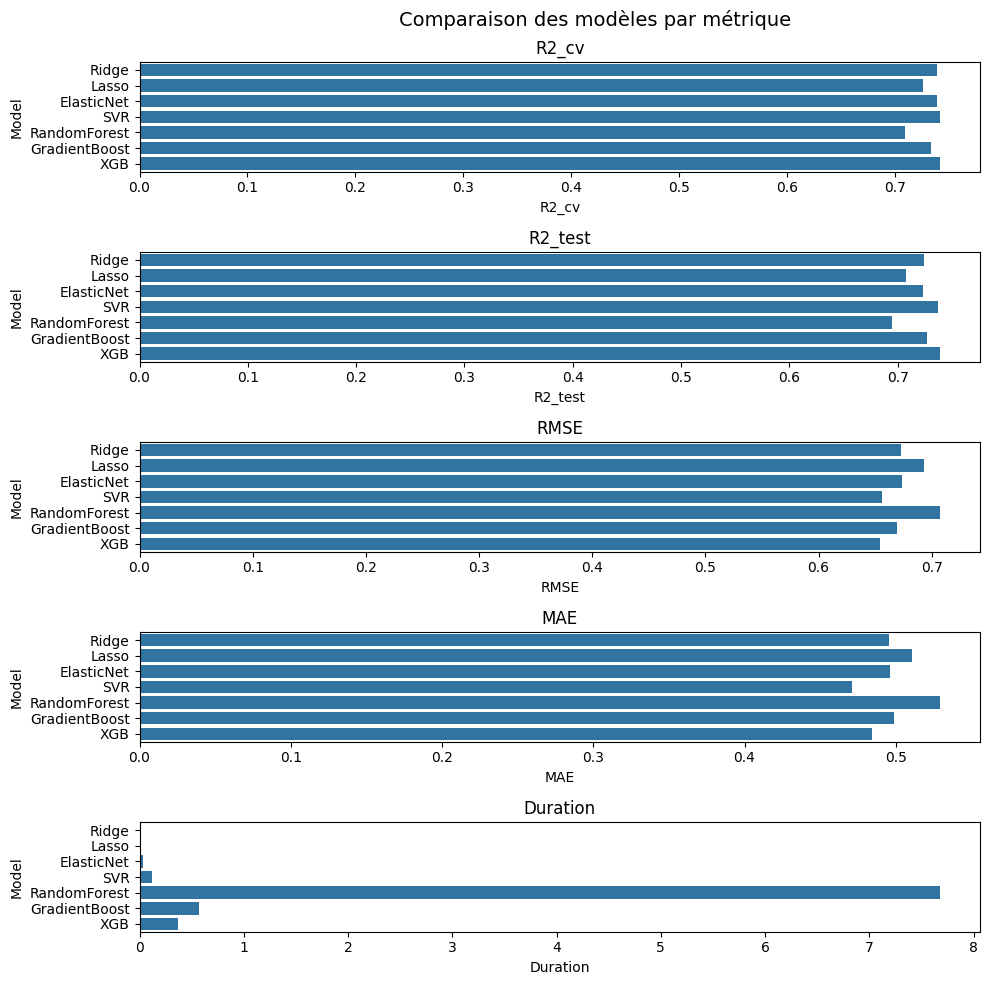

In [414]:
# Visualisation des résultats des différents modèles :

fine_grid_results_df.set_index('Model', inplace=True)

# Création du subplot
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

# Barplot pour R2_cv
sns.barplot(x='R2_cv', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[0])
axs[0].set_title('R2_cv')

# Barplot pour R2_test
sns.barplot(x='R2_test', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[1])
axs[1].set_title('R2_test')

# Barplot pour RMSE
sns.barplot(x='RMSE', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[2])
axs[2].set_title('RMSE')

# Barplot pour MAE
sns.barplot(x='MAE', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[3])
axs[3].set_title('MAE')

# Barplot pour Duration
sns.barplot(x='Duration', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[4])
axs[4].set_title('Duration')

# Ajout d'un titre global
plt.suptitle('Comparaison des modèles par métrique', fontsize=14, x=0.6)

# Ajustements pour un meilleur affichage
plt.tight_layout()
plt.show()

Les performances entre le SVR et le XGBRegressor sont assez similaires et **notre choix se portera sur ce le modèle XGBRegressor pour la suite de l'analyse.**

**Visualisation des performances du modèle :**

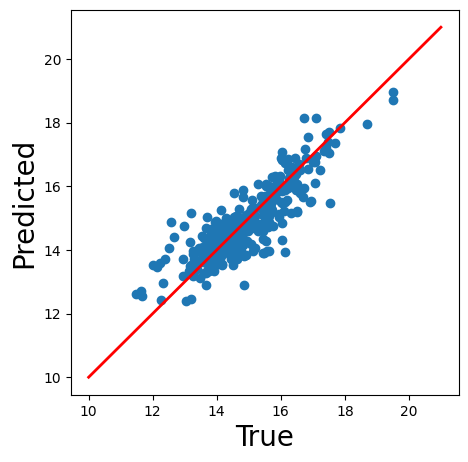

In [415]:
# on récupère les prédictions du modèle XGBRegressor :
pred_test = grid_xgb.predict(X_test_scaled)

# Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))

plt.scatter(y_test_scaled, pred_test)
plt.plot([10, 21],
         [10, 21],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)

plt.show()

## 9.Feature Importance

### 9.1. Feature Importance globale

#### 9.1.1. Méthode du modèle

In [540]:
xgb_imp = grid_xgb.feature_importances_

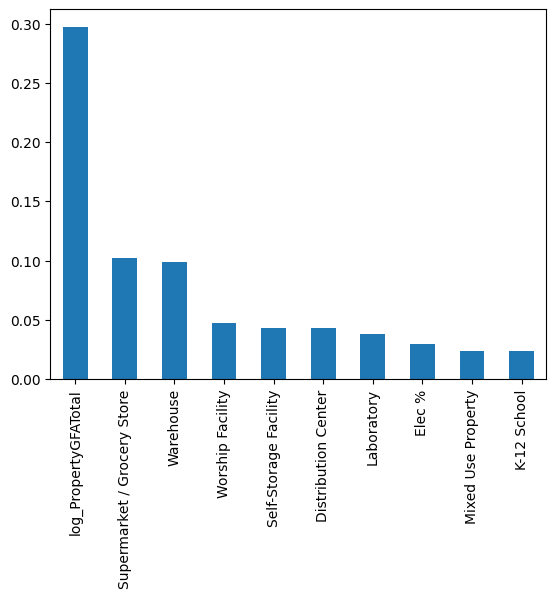

In [541]:
fxgb_importance = pd.Series(xgb_imp, index = X_train_scaled_df.columns).nlargest(10).plot(kind = 'bar')

Via la méthode 'feature_importances_' du modèle XGBRegressor, on peur voir quelles ont été les variables les plus impactantes pour l'entrainement du modèle et pour ses prédictions.
On note ici que la surface totale a eu un poids bien plus conséquent que les autres variables. Viennent ensuite le nombre d'étages et quelques types d'usage des bâtiments tels que Supermarket / Grocery Store et Warehouse.
Cependant cette méthode ne nous indique pas dans quel sens ces variables ont influencé la prédiction, ont-elles eu un impact négatif, c'est-à-dire tendant à diminuer la valeur de la prédiction ? Ou positif, c'est à dire tendant à l'augmenter ?

Pour avoir plus de détails sur ces questions nous allons utiliser la librairie SHAP.

#### 9.1.2. SHAP

In [542]:
shap.initjs

<function shap.plots._force.initjs()>

In [543]:
# Get shap values
explainer = shap.Explainer(grid_xgb)
shap_values = explainer(X_test_scaled)

# sample of shape_values : shap_values = explainer(X_test_scaled[0:100])

In [544]:
shap_values.feature_names = X_train_scaled_df.columns

In [545]:
np.shape(shap_values.values)

(325, 33)

In [546]:
features_names = X_train_scaled_df.columns

**Absolute Mean SHAP**

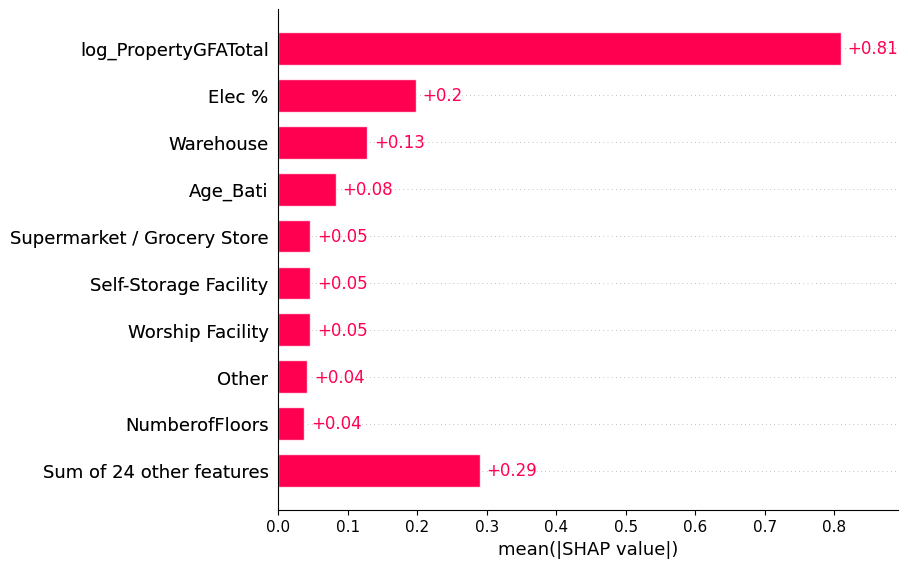

In [547]:
shap.plots.bar(shap_values)

**Summary plot**

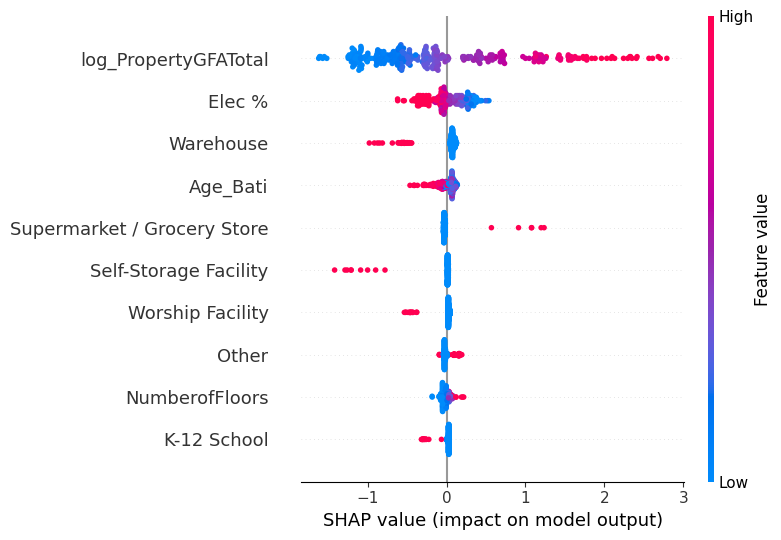

In [548]:
shap.summary_plot(shap_values, max_display=10)

Ce graphique nous permet de déceler les relations existantes entre nos variables et la target.
On voit par exemple que plus les valeurs de la surface, et du nombre d'étages sont grandes, et plus la consommation d'énergie prédite par le modèle est élevée. Il en va de même si le type d'usage est commercial, où pour la catégorie 'Autre'.

A l'inverse on voit que plus la proportion d'électricité utilisée dans le mix énergétique d'un bâtiment est élevée, et plus la consommation d'énergie prédite sera faible. Surprenamment, il en va de même concernant l'âge du bâtiment et le fait qu'il soit de type Entrepôt.

**Dependance Plot**

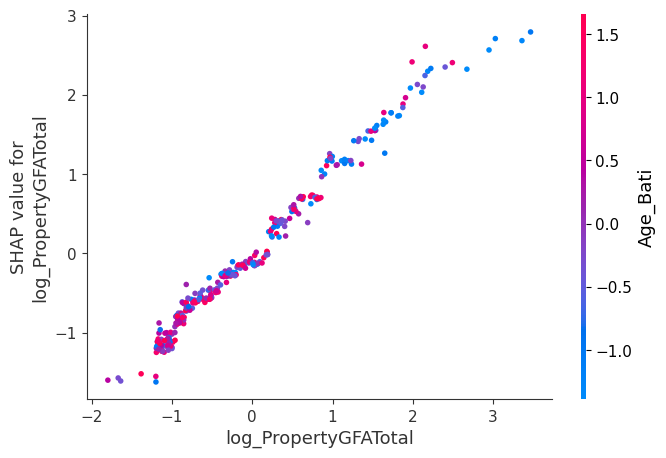

In [549]:
shap.dependence_plot('log_PropertyGFATotal',
                     explainer.shap_values(X_test_scaled),
                     features = X_test_scaled,
                     feature_names = features_names
                     )

### 9.2. Feature Importance locale

Il s'agit ici de montrer le poids de certaines caractéristiques dans les prédictions du modèle pour un individu seulement.

**Bar plot**

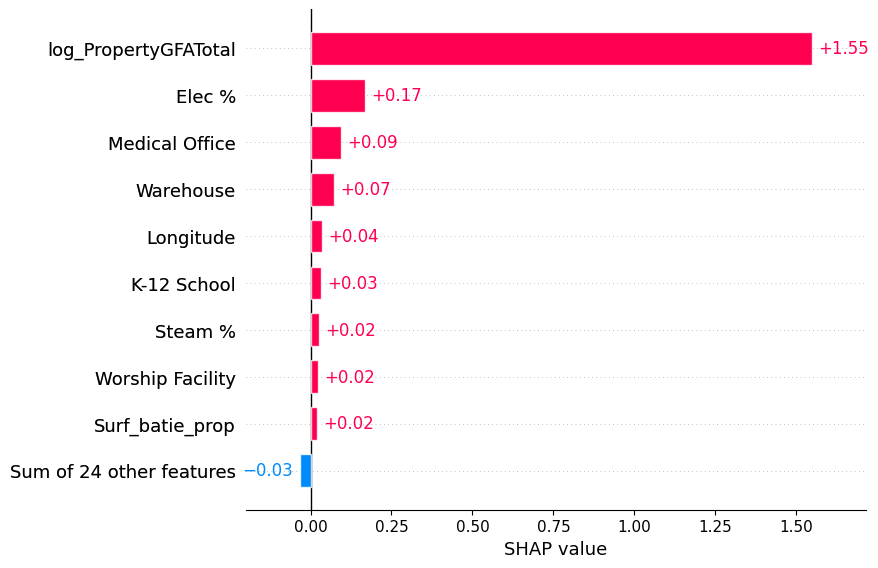

In [550]:
shap.plots.bar(shap_values[50])

Pour l'exemple sélectionné ici, de manière arbitraire, on voir que la surface, le nombre d'étage et la proportion d'utilisation d'électricité dans le mix énergétique ont eu une influence positive dans la détermination de la prédiction de consommation totale d'énergie.

**Waterfall plot**

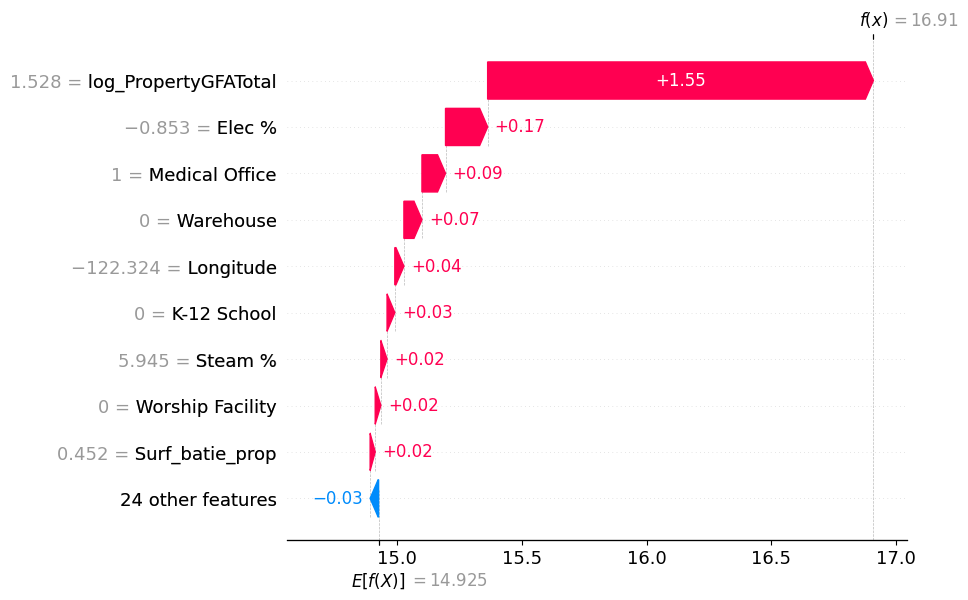

In [551]:
shap.plots.waterfall(shap_values[50])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

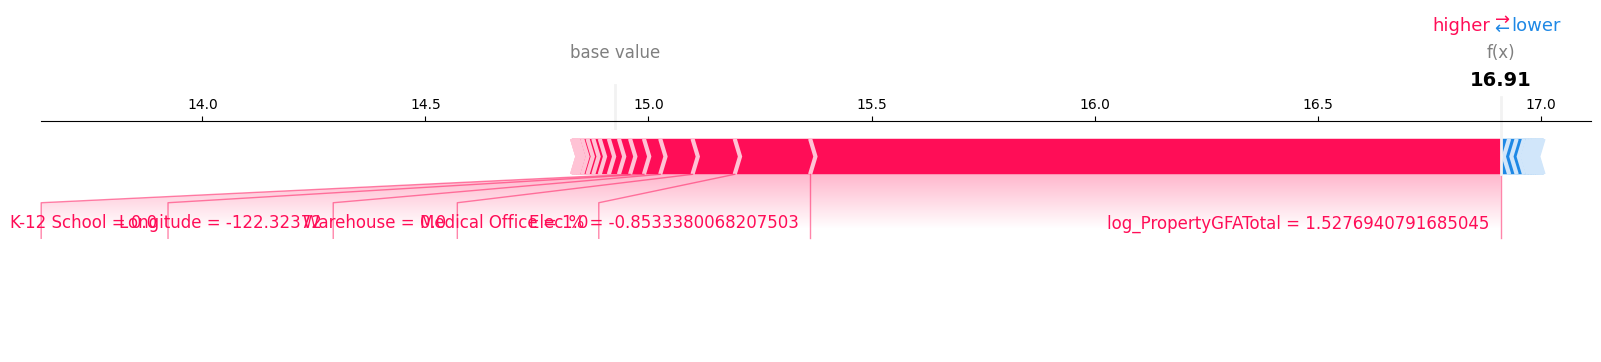

In [552]:
shap.plots.force(shap_values[50],
                 matplotlib = matplotlib)

De même ici.

Prenons un autre exemple :

**Bar plot**

In [553]:
sample_idx = int(np.random.uniform(0, X_test_scaled.shape[0]))

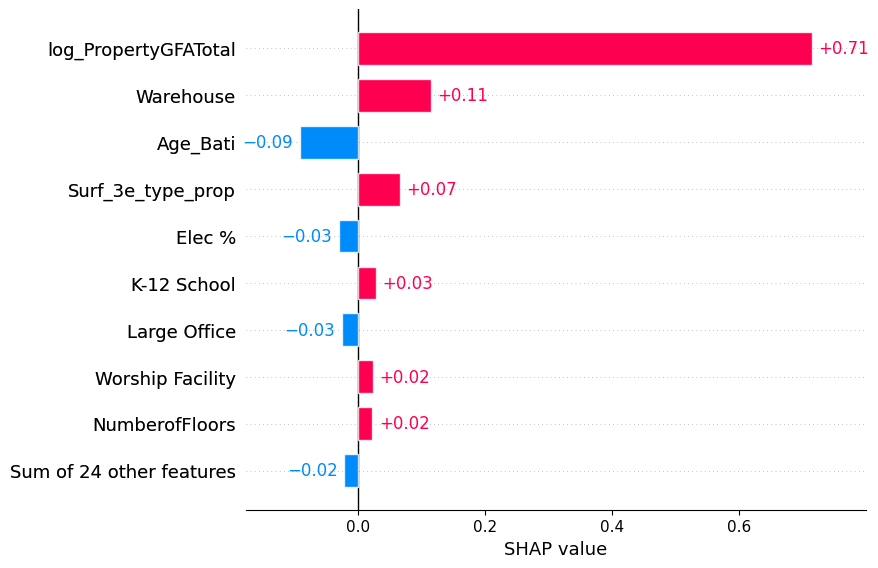

In [554]:
shap.plots.bar(shap_values[sample_idx])

On voit cette fois que la surface totale a un impact négatif sur la prédiction de la consommation d'énergie, de même que l'âge du bâtiment.
A l'inverse la proportion d'utilisation d'électricité dans le mix énergétique et le type de bâtiment 'Other' ont un impact positif.

**Waterfall plot**

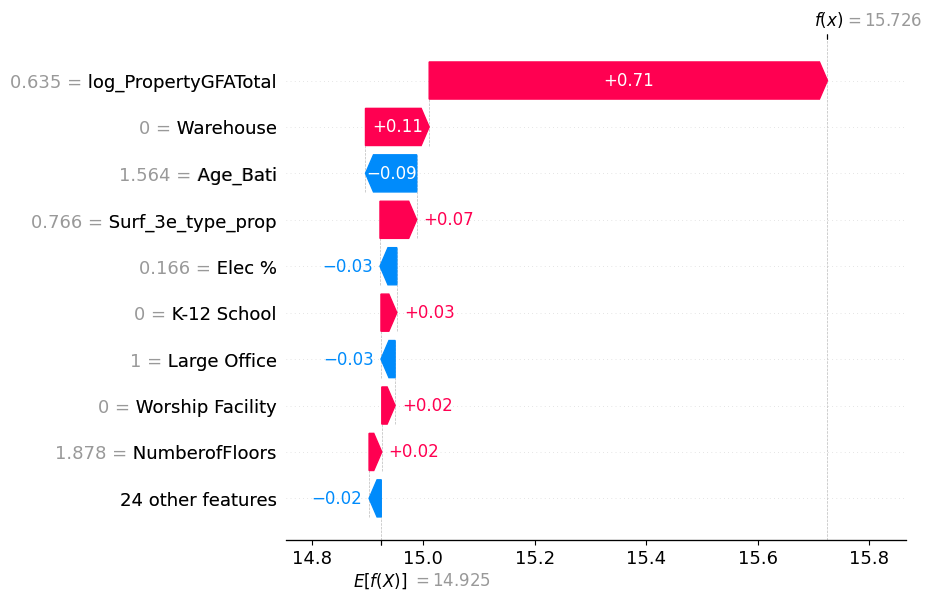

In [555]:
#shap_values.feature_names = X_train_scaled_df.columns
shap.plots.waterfall(shap_values[sample_idx])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

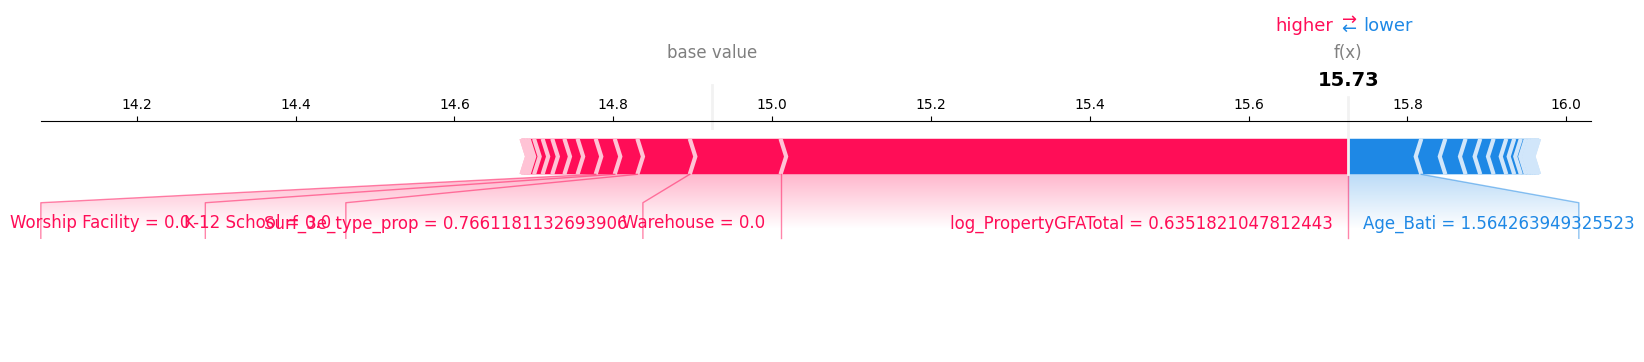

In [556]:
shap.plots.force(shap_values[sample_idx],
                 matplotlib = matplotlib)

## 10.Influence de l'Energy Star Score

### 10.1. Modification du jeu de données

On modifie le jeu de données en conséquences car cette variable a des données manquantes.

In [557]:
data.columns

Index(['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Age_Bati', 'Steam %',
       'Elec %', 'NaturalGas %', 'UseTypesNumber', 'Surf_1er_type_prop',
       'Surf_2e_type_prop', 'Surf_3e_type_prop', 'Surf_batie_prop',
       'Surf_parking_prop', 'log_PropertyGFATotal'],
      dtype='object')

In [558]:
data_2 = data[~data['ENERGYSTARScore'].isna()]
data_2.isna().mean()

PrimaryPropertyType               0.0000
Latitude                          0.0000
Longitude                         0.0000
NumberofBuildings                 0.0000
NumberofFloors                    0.0000
PropertyGFATotal                  0.0000
PropertyGFAParking                0.0000
PropertyGFABuilding(s)            0.0000
ListOfAllPropertyUseTypes         0.0000
SecondLargestPropertyUseTypeGFA   0.5378
ENERGYSTARScore                   0.0000
SiteEnergyUse(kBtu)               0.0000
TotalGHGEmissions                 0.0000
Age_Bati                          0.0000
Steam %                           0.0000
Elec %                            0.0000
NaturalGas %                      0.0000
UseTypesNumber                    0.0000
Surf_1er_type_prop                0.0000
Surf_2e_type_prop                 0.0000
Surf_3e_type_prop                 0.0000
Surf_batie_prop                   0.0000
Surf_parking_prop                 0.0000
log_PropertyGFATotal              0.0000
dtype: float64

**Préparation des données**

In [559]:
# Etablissement de plusieurs choix de variables explicatives :

var_exp_sansess = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

numerical_features_sansess = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

categorical_features = ['PrimaryPropertyType']

var_exp_avecess = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop', 'ENERGYSTARScore']

numerical_features_avecess = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop', 'ENERGYSTARScore']

On utilisera donc notre transformation StandardScaler() pour les données numériques et un OneHotEncoder sur le type d'usage de bâtiment.

In [560]:
# Pour les variables explicatives :
stand_transformer_sansess = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numerical_features_sansess), remainder='passthrough')
stand_transformer_avecess = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numerical_features_avecess), remainder='passthrough')

# Pour la variable cible :
target_transfo = FunctionTransformer(func = np.log1p, inverse_func = np.expm1)

### 10.2. Entrainement du modèle sans l'Energy Star Score

Je sépare mes variables entre variables explicatives (exogènes) d'un coté et expliquée (endogène) de l'autre :

In [561]:
X = data_2[var_exp_sansess]
y = data_2['SiteEnergyUse(kBtu)']

Puis je crée des jeux de données d'entrainement et de test :

In [562]:
# split des données :

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=30)

**Transformation des données :**

In [563]:
# Je transforme les données explicatives :
X_train_scaled = stand_transformer_sansess.fit_transform(X_train)
X_test_scaled = stand_transformer_sansess.transform(X_test)

# Et cible :
y_train_scaled = target_transfo.fit_transform(y_train)
y_test_scaled = target_transfo.transform(y_test)

Création d'un DF Xtrain_scaled pour l'analyse de feature

In [564]:
# Pour les features importances on récupères les noms de colonnes de nos jeu de données :
feature_names_encoded = stand_transformer_sansess.get_feature_names_out(X_train.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = feature_names_encoded)
X_train_scaled_df.rename(columns=lambda x: x.replace('onehotencoder__PrimaryPropertyType_', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('standardscaler__', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)

On entraine le modèle et affiche ses résultats :

In [565]:
xgb_sansess = XGBRegressor(colsample_bytree = 0.8, gamma = 0.2, learning_rate = 0.03, max_depth = 3, min_child_weight = 5, n_estimators = 550, reg_lambda = 1.1,
                             subsample = 0.7, random_state = 42)
start_time = time.time()
xgb_sansess.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [566]:
# cross val score :
r2_cv = cross_val(xgb_sansess, X_train_scaled, y_train_scaled)

In [567]:
pred_train = xgb_sansess.predict(X_train_scaled)
pred_test = xgb_sansess.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.28494803643145794 		 MAE test: 0.39777881966216444
MSE train: 0.15317878525833536 		 MSE test: 0.32156008618098525
RMSE train: 0.3913806143108462 		 RMSE test: 0.5670626827617783
R2 train: 0.9036559450376338 		 R2 test: 0.832841810285201
__________________________________


In [568]:
# On récupère les résultats dans un Dataframe :
xgb_sansess_results_df = pd.DataFrame(data=[["XGB_sansess", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])

display(xgb_sansess_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,XGB_sansess,0.3978,0.5671,0.8328,0.9037,0.7852,0.9384


On voit qu'on a des résultats sensiblement meilleurs que ceux du modèle précédent. On a même un peu moins d'overfitting ici même s'il est toujours présent.
Visualisation l'adéquation de nos données prédites avec les valeurs réelles :

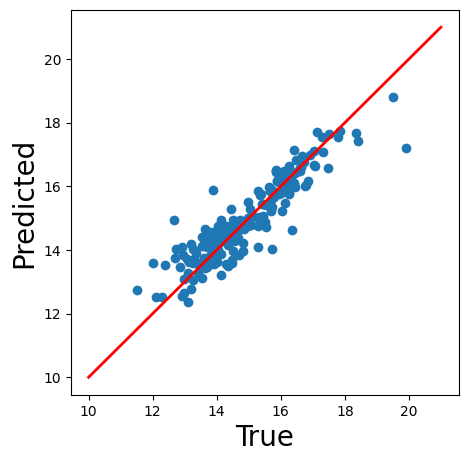

In [569]:
# Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))

plt.scatter(y_test_scaled, pred_test)
plt.plot([10, 21],
         [10, 21],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)

plt.show()

On voit en effet que le modèle prédit plutôt bien la consommation d'énergie et est assez proche des valeurs réelles.

#### Feature Importance

**Feature Importance globale**

**Méthode du modèle**

In [570]:
xgb_sansess_imp = xgb_sansess.feature_importances_

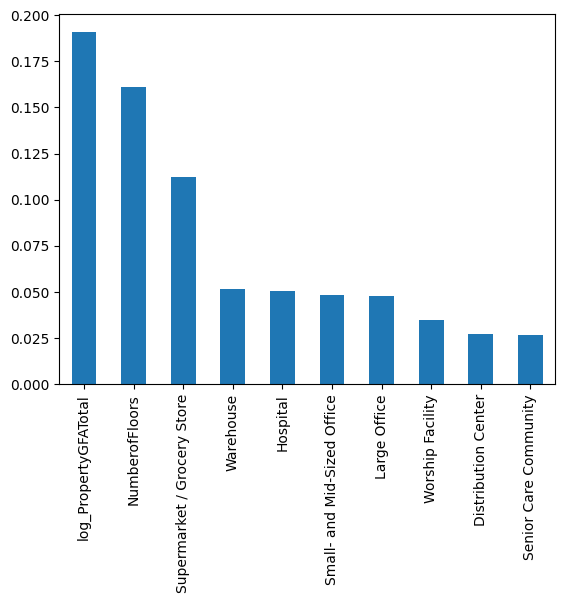

In [571]:
fxgb_sansess_importance = pd.Series(xgb_sansess_imp, index = X_train_scaled_df.columns).nlargest(10).plot(kind = 'bar')

On note ici que l'importance des variables dans la prédiction est un peu plus équilibrée qu'auparavant.
La surface totale a toujours un poids conséquent mais suivie de près par le nombre d'étages et les types d'usage du bâtiment.

**SHAP**

In [572]:
# Get shap values
explainer = shap.Explainer(xgb_sansess)
shap_values = explainer(X_test_scaled)

# sample of shape_values : shap_values = explainer(X_test_scaled[0:100])

In [573]:
np.shape(shap_values.values)

(215, 29)

In [574]:
shap_values.feature_names = X_train_scaled_df.columns

In [575]:
features_names = X_train_scaled_df.columns

**Absolute Mean SHAP**

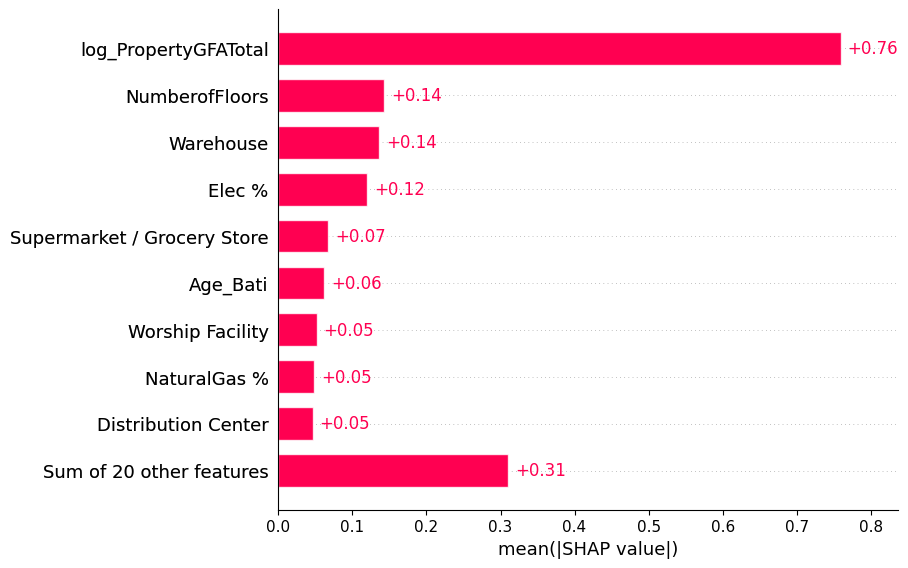

In [576]:
shap.plots.bar(shap_values)

**Summary plot**

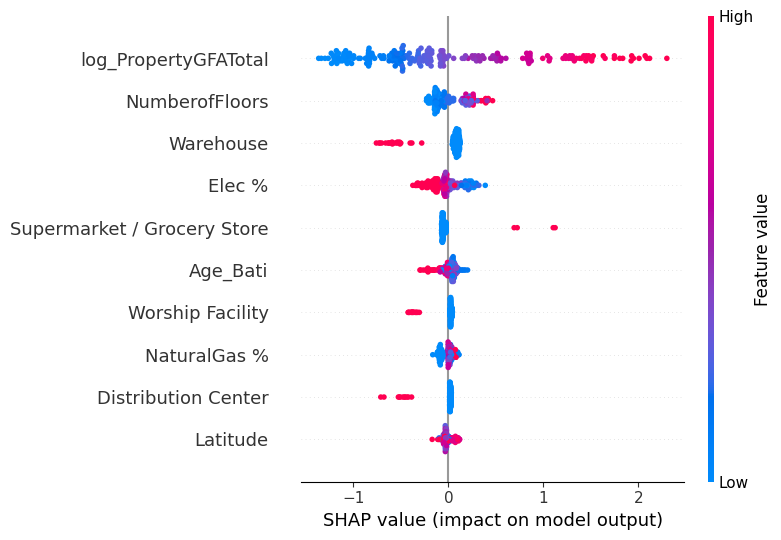

In [577]:
shap.summary_plot(shap_values, max_display=10)

On peut ici faire les mêmes commentaires que précédemment.

**Dependance Plot**

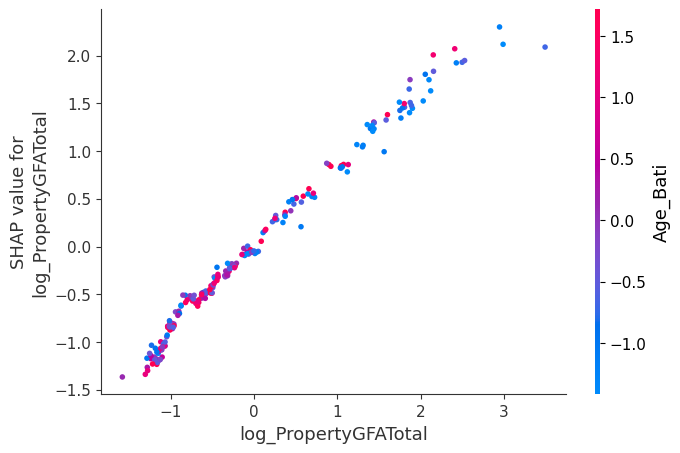

In [578]:
shap.dependence_plot('log_PropertyGFATotal',
                     explainer.shap_values(X_test_scaled),
                     features = X_test_scaled,
                     interaction_index="Age_Bati",
                     feature_names = features_names
                     )

#### Feature Importance locale

Il s'agit ici de montrer le poids de certaines caractéristiques dans les prédictions du modèle pour un individu seulement.

**Bar plot**

In [579]:
sample_idx = int(np.random.uniform(0, X_test_scaled.shape[0]))

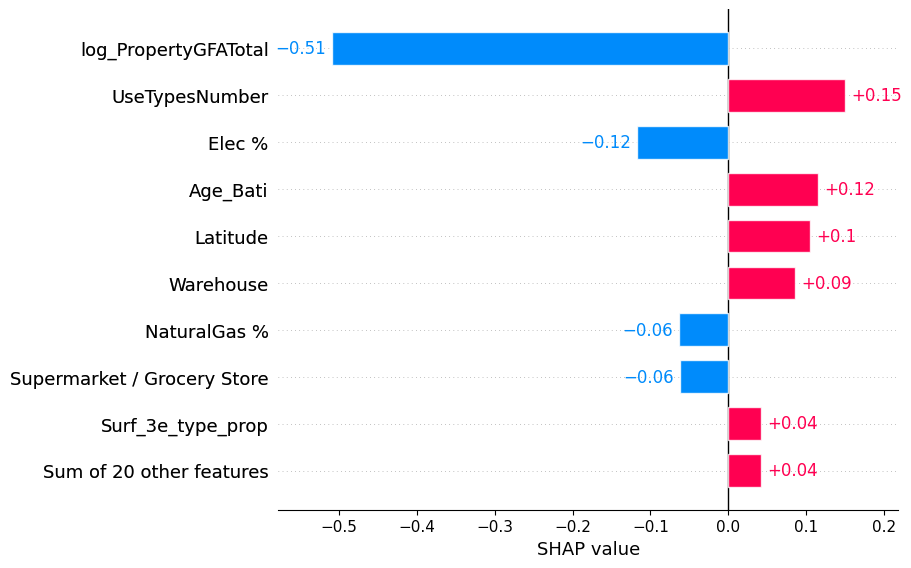

In [580]:
shap.plots.bar(shap_values[sample_idx])

On voit cette fois que la surface totale a un impact négatif sur la prédiction de la consommation d'énergie, de même que la proportion d'utilisation d'électricité dans le mix énergétique.

**Waterfall plot**

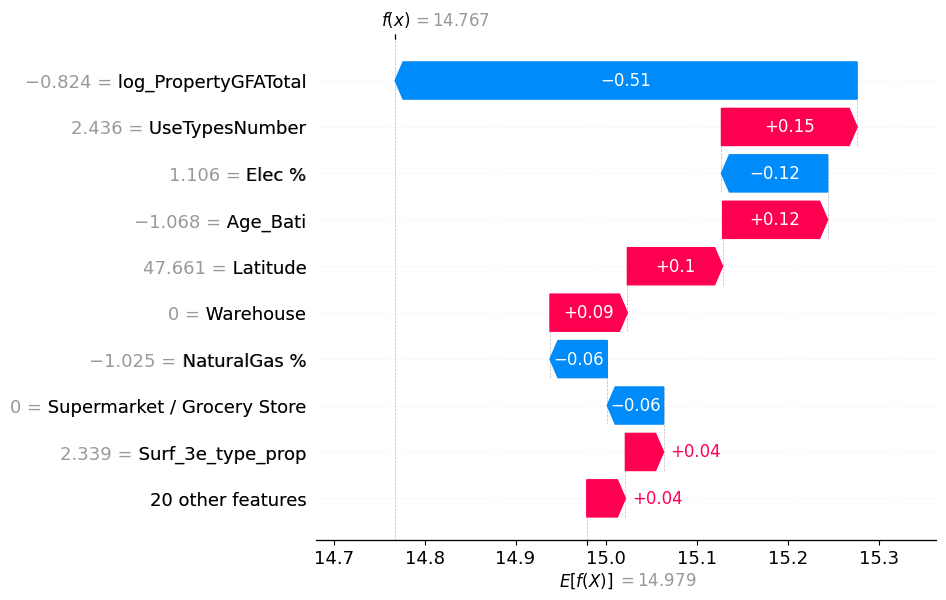

In [581]:
#shap_values.feature_names = X_train_scaled_df.columns
shap.plots.waterfall(shap_values[sample_idx])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

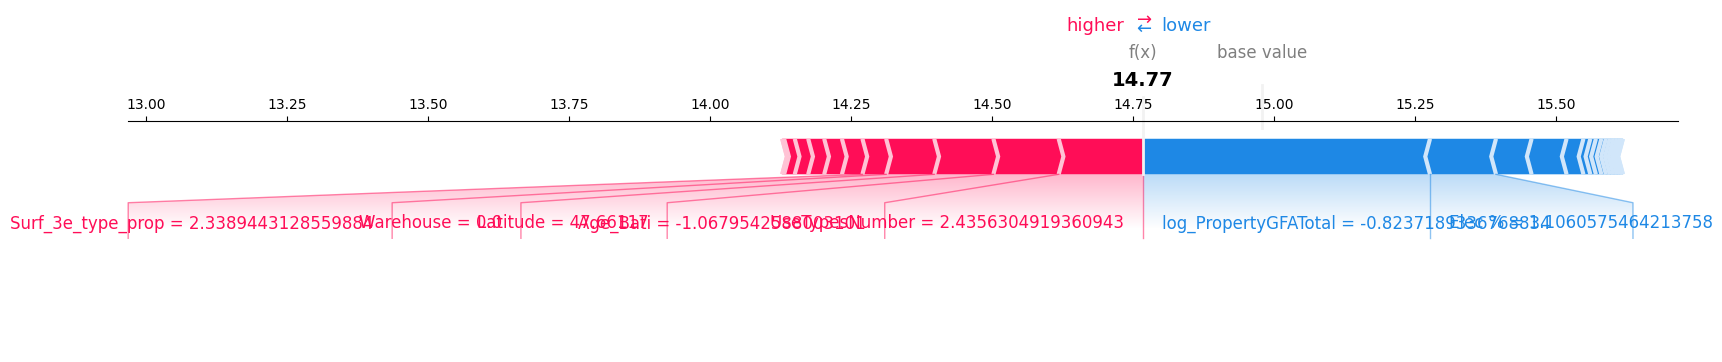

In [582]:
shap.plots.force(shap_values[sample_idx],
                 matplotlib = matplotlib)

### 10.3. Intégration de l'Energy Star Score

Je sépare mes variables entre variables explicatives (exogènes) d'un coté et expliquée (endogène) de l'autre :

In [583]:
X = data_2[var_exp_avecess]
y = data_2['SiteEnergyUse(kBtu)']

Puis je crée des jeux de données d'entrainement et de test :

In [584]:
# split des données :

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=30)

**Transformation des données :**

In [585]:
# Je transforme les données explicatives :
X_train_scaled = stand_transformer_avecess.fit_transform(X_train)
X_test_scaled = stand_transformer_avecess.transform(X_test)

# Et cible :
y_train_scaled = target_transfo.fit_transform(y_train)
y_test_scaled = target_transfo.transform(y_test)

Création d'un DF Xtrain_scaled pour l'analyse de feature

In [586]:
# Pour les features importances on récupères les noms de colonnes de nos jeu de données :
feature_names_encoded = stand_transformer_avecess.get_feature_names_out(X_train.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = feature_names_encoded)
X_train_scaled_df.rename(columns=lambda x: x.replace('onehotencoder__PrimaryPropertyType_', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('standardscaler__', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)

On entraine le modèle et affiche ses résultats :

In [587]:
xgb_avecess = XGBRegressor(colsample_bytree = 0.8, gamma = 0.2, learning_rate = 0.03, max_depth = 3, min_child_weight = 5, n_estimators = 550, reg_lambda = 1.1,
                             subsample = 0.7, random_state = 42)
start_time = time.time()
xgb_avecess.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [588]:
# cross val score :
r2_cv = cross_val(xgb_avecess, X_train_scaled, y_train_scaled)

In [589]:
pred_train = xgb_avecess.predict(X_train_scaled)
pred_test = xgb_avecess.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.1948539675480236 		 MAE test: 0.2989673158192245
MSE train: 0.07247783913622109 		 MSE test: 0.184517649833111
RMSE train: 0.26921708552062795 		 RMSE test: 0.429555176703891
R2 train: 0.954413994695694 		 R2 test: 0.9040812661706648
__________________________________


In [590]:
# On récupère les résultats dans un Dataframe :
xgb_avecess_results_df = pd.DataFrame(data=[["XGB_avecess", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])

display(xgb_avecess_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,XGB_avecess,0.2990,0.4296,0.9041,0.9544,0.8831,0.3595


L'intégration de l'Energy Star Score améliore les résultats du modèle mais on a encore une fois une hausse de l'overfitting. Cela est probablement dû ici à du dataleakage, la variable Energy Star Score étant liée à notre variable cible : la consommation totale d'énergie.

Comparaison des scores sans et avec l'Energy Star Score :

In [591]:
comp_df = pd.concat([xgb_sansess_results_df, xgb_avecess_results_df], ignore_index = True)
display(comp_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,XGB_sansess,0.3978,0.5671,0.8328,0.9037,0.7852,0.9384
1,XGB_avecess,0.2990,0.4296,0.9041,0.9544,0.8831,0.3595


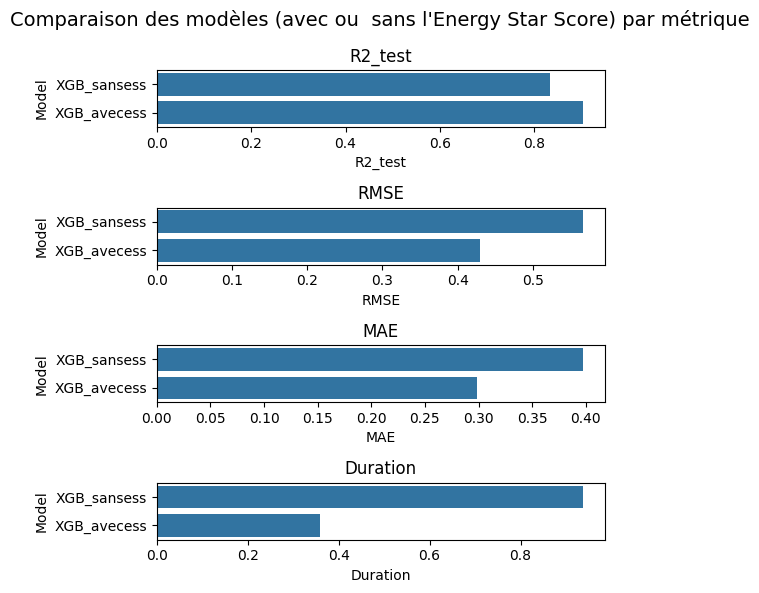

In [592]:
# Visualisation des résultats des différents modèles :

comp_df.set_index('Model', inplace=True)

# Création du subplot
fig, axs = plt.subplots(4, 1, figsize=(6, 6))

# Barplot pour R2_test
sns.barplot(x='R2_test', y=comp_df.index, data=comp_df, ax=axs[0])
axs[0].set_title('R2_test')

# Barplot pour RMSE
sns.barplot(x='RMSE', y=comp_df.index, data=comp_df, ax=axs[1])
axs[1].set_title('RMSE')

# Barplot pour MAE
sns.barplot(x='MAE', y=comp_df.index, data=comp_df, ax=axs[2])
axs[2].set_title('MAE')

# Barplot pour Duration
sns.barplot(x='Duration', y=comp_df.index, data=comp_df, ax=axs[3])
axs[3].set_title('Duration')

# Ajout d'un titre global
plt.suptitle("Comparaison des modèles (avec ou  sans l'Energy Star Score) par métrique", fontsize=14, x=0.6)

# Ajustements pour un meilleur affichage
plt.tight_layout()
plt.show()

Visualisation l'adéquation de nos données prédites avec les valeurs réelles :

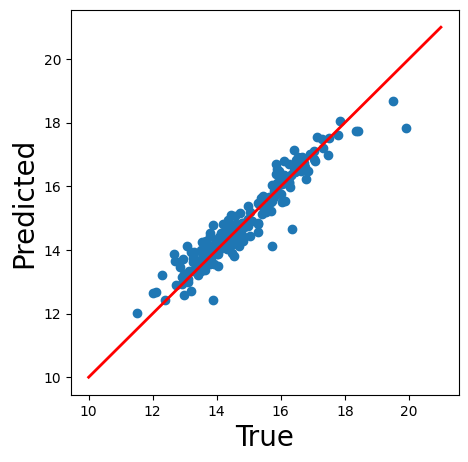

In [593]:
# Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))

plt.scatter(y_test_scaled, pred_test)
plt.plot([10, 21],
         [10, 21],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)

plt.show()

On voit en effet que le modèle prédit plutôt bien la consommation d'énergie et est assez proche des valeurs réelles.

#### Feature Importance

**Feature Importance globale**

**Méthode du modèle**

In [594]:
xgb_avecess_imp = xgb_avecess.feature_importances_

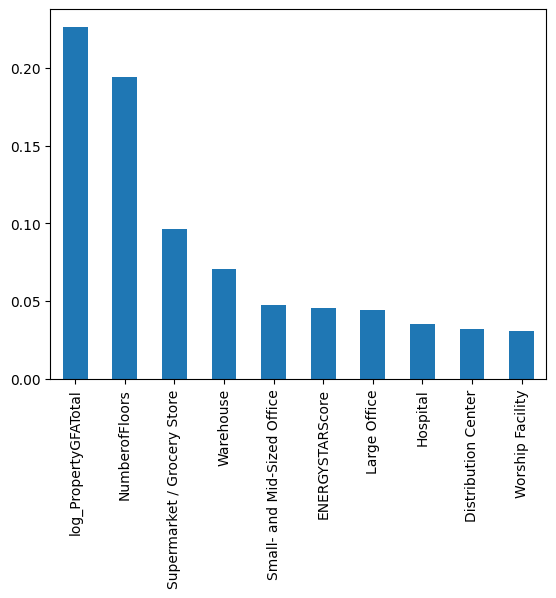

In [595]:
fxgb_avecess_importance = pd.Series(xgb_avecess_imp, index = X_train_scaled_df.columns).nlargest(10).plot(kind = 'bar')

La variable 'Energy Star Score' fait partie des 10 variables les plus importantes dans la détermination de la prédiction. Cependant son poids ne semble pas très conséquent et est assez loin de ceux de la surface totale et du nombre d'étages.

**SHAP**

In [596]:
# Get shap values
explainer = shap.Explainer(xgb_avecess)
shap_values = explainer(X_test_scaled)

# sample of shape_values : shap_values = explainer(X_test_scaled[0:100])

In [597]:
np.shape(shap_values.values)

(215, 30)

In [598]:
shap_values.feature_names = X_train_scaled_df.columns

In [599]:
X_train_scaled_df.columns

Index(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School',
       'Large Office', 'Medical Office', 'Mixed Use Property', 'Other',
       'Refrigerated Warehouse', 'Retail Store', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'Warehouse', 'Worship Facility', 'NumberofFloors',
       'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %',
       'UseTypesNumber', 'Surf_batie_prop', 'Surf_parking_prop',
       'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop',
       'ENERGYSTARScore', 'Latitude', 'Longitude'],
      dtype='object')

In [600]:
features_names = X_train_scaled_df.columns

**Absolute Mean SHAP**

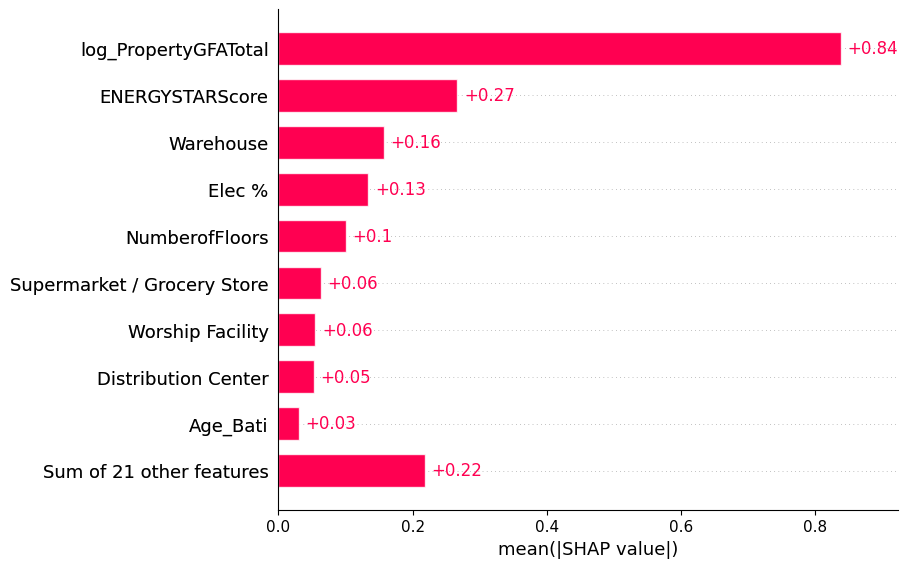

In [601]:
shap.plots.bar(shap_values)

L'utilisation du package SHAP semble montrer que l'Energy Star Score a une importance tout de même assez élevée, se plaçant en 2e position derrière la surface totale.

**Summary plot**

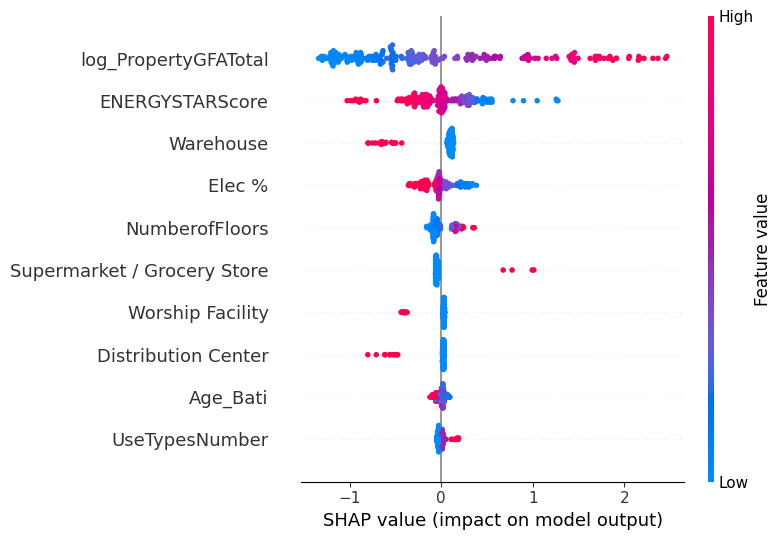

In [602]:
shap.summary_plot(shap_values, max_display=10)

La relation entre notre variable cible et l'Energy Star Score est négative, ce qui semble logique dans la mesure où plus le score de cet indicateur est élevé et plus on est censé avoir une consommation d'énergie raisonnable.

**Dependance Plot**

In [603]:
features_names

Index(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School',
       'Large Office', 'Medical Office', 'Mixed Use Property', 'Other',
       'Refrigerated Warehouse', 'Retail Store', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'Warehouse', 'Worship Facility', 'NumberofFloors',
       'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %',
       'UseTypesNumber', 'Surf_batie_prop', 'Surf_parking_prop',
       'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop',
       'ENERGYSTARScore', 'Latitude', 'Longitude'],
      dtype='object')

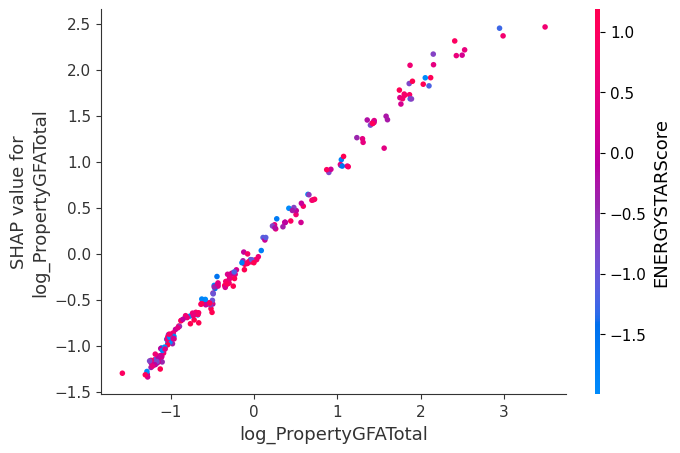

In [604]:
shap.dependence_plot('log_PropertyGFATotal',
                     explainer.shap_values(X_test_scaled),
                     features = X_test_scaled,
                     interaction_index = 'ENERGYSTARScore',
                     feature_names = features_names
                     )

#### 2. Feature Importance locale

Il s'agit ici de montrer le poids de certaines caractéristiques dans les prédictions du modèle pour un individu seulement.

**Bar plot**

In [605]:
sample_idx = int(np.random.uniform(0, X_test_scaled.shape[0]))

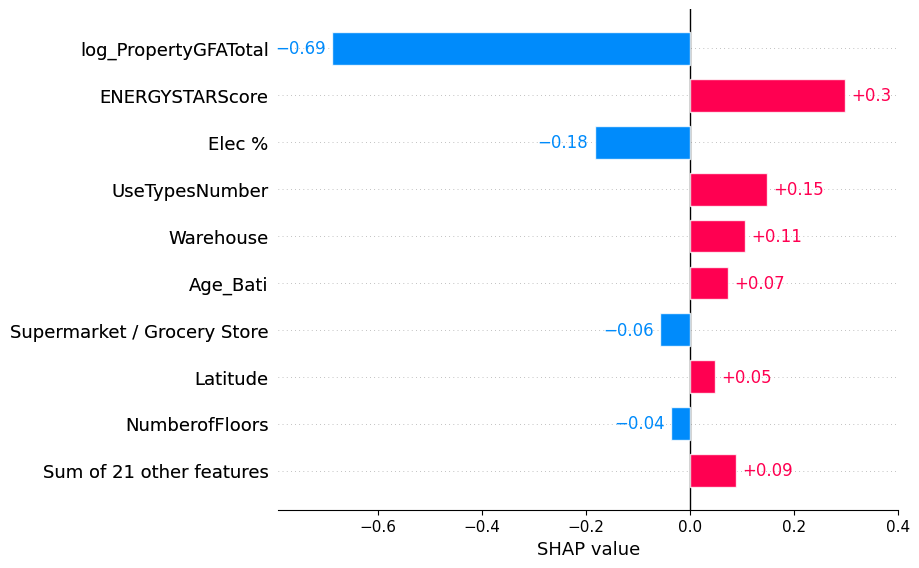

In [606]:
shap.plots.bar(shap_values[sample_idx])

On voit cette fois que la surface totale a un impact négatif sur la prédiction de la consommation d'énergie, à l'inverse de l'Energy Star Score. On a probalement ici à faire à un bâtiment ayant une surface plutôt faible comparé aux autres mais ayant également un Energy Star Score assez faible.

**Waterfall plot**

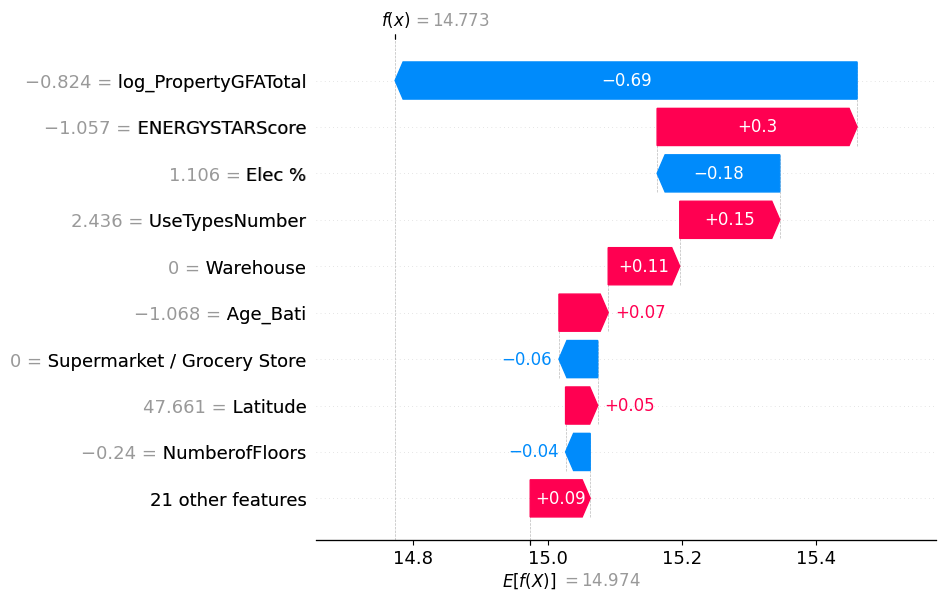

In [607]:
#shap_values.feature_names = X_train_scaled_df.columns
shap.plots.waterfall(shap_values[sample_idx])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

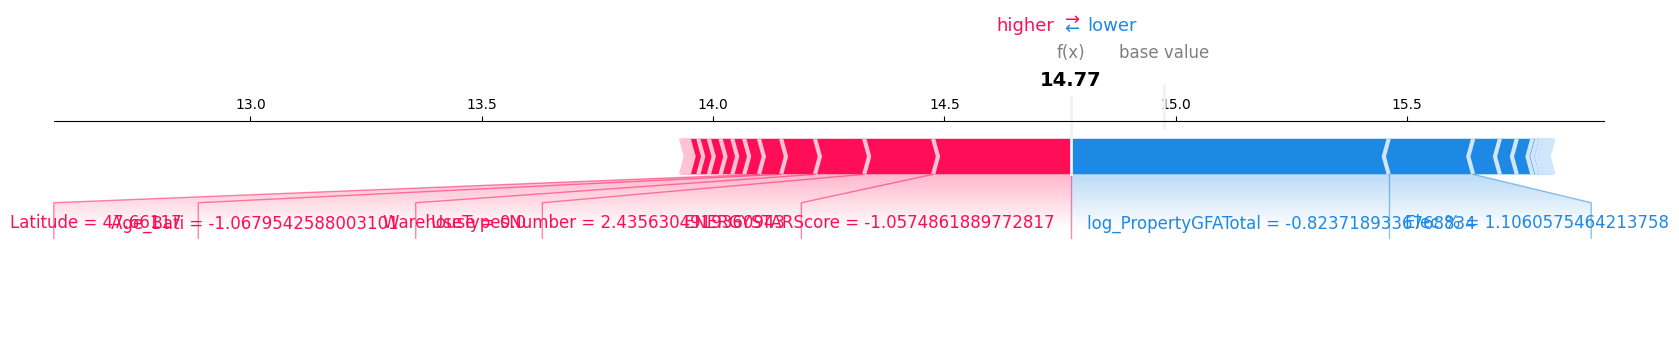

In [608]:
shap.plots.force(shap_values[sample_idx],
                 matplotlib = matplotlib)